<a href="https://colab.research.google.com/github/BalytskyiJaroslaw/PathogensRamanOpenSet/blob/main/Naive_K_p_1_p_2_p_3_submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive thresholding, $\mathcal{K} = p_1+p_2+p_3$, $\mathcal{I}$ = $∅$, $\mathcal{N}$ = $∅$

In [ ]:
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
from numpy import genfromtxt
from sklearn.utils import shuffle


import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from pandas import read_csv

from keras.layers import Lambda, Multiply
import csv
import pprint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import keras
#from keras.utils import to_categorical
from pandas import read_csv
from keras.models import Sequential
from keras import layers
#from keras.optimizers import SGD
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
#from keras.optimizers import SGD

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint

from sklearn.preprocessing import LabelEncoder
import gspread
import pandas as pd
import pickle
import pywt
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
#from keras.utils import to_categorical

from time import time
t00 = time()
import os
from tensorflow.keras import layers
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from keras.layers import GlobalAveragePooling1D

# Initializing TPU

In [ ]:
# Initialize the TPU and spread the computations across the 8 cores
import tensorflow as tf
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
tf.config.list_logical_devices('TPU')
#print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)

# Uploading the data

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Reference dataset

In [ ]:
# Reference data
data_X_reference = np.load("/content/gdrive/MyDrive/Stanford_data/X_reference.npy")
# Test data
data_X_test = np.load("/content/gdrive/MyDrive/Stanford_data/X_test.npy")

data_y_reference = np.load("/content/gdrive/MyDrive/Stanford_data/y_reference.npy")
# Test labels
data_y_test = np.load("/content/gdrive/MyDrive/Stanford_data/y_test.npy")

data_y_reference_int = []

for i in range(data_y_reference.shape[0]):
  data_y_reference_int.append(int(data_y_reference[i]))

data_y_test_int = []

for i in range(data_y_test.shape[0]):
  data_y_test_int.append(int(data_y_test[i]))

train_label = tf.keras.utils.to_categorical(data_y_reference_int)
test_label = tf.keras.utils.to_categorical(data_y_test_int)

# The case of $\mathcal{K} = p_1+p_2+p_3$, corresponds to the known training reference indices: 10000 - 14000, 18000 - 38000, 42000 - 50000,52000 - 60000

In [ ]:
indices = [slice(10000, 14000),slice(18000, 38000),slice(42000, 50000),slice(52000, 60000)]

Known_data_X_reference = np.concatenate([data_X_reference[idx, :] for idx in indices], axis=0)

Known_data_X_train_label_int = []

for i in range(2000*20):
  Known_data_X_train_label_int.append(int(data_y_reference[i]))

Known_data_X_train_label = tf.keras.utils.to_categorical(Known_data_X_train_label_int)
print("Shape of the known data, reference:", Known_data_X_reference.shape)
print("Shape of the known labels, reference:", Known_data_X_train_label.shape)

Shape of the known data, reference: (40000, 1000)
Shape of the known labels, reference: (40000, 20)


# Known data indices, testing dataset. Indices = 500-700, 900-1900, 2100 -2500,2600 - 3000.


In [ ]:
indices = [slice(500, 700),slice(900, 1900),slice(2100, 2500),slice(2600, 3000)]

Known_data_X_test = np.concatenate([data_X_test[idx, :] for idx in indices], axis=0)

Known_data_X_test_label_int = []

for i in range(100*20):
  Known_data_X_test_label_int.append(int(data_y_test[i]))

Known_data_X_test_label = tf.keras.utils.to_categorical(Known_data_X_test_label_int)
print("Shape of the known data, test:", Known_data_X_test.shape)
print("Shape of the known labels, test:", Known_data_X_test_label.shape)

Shape of the known data, test: (2000, 1000)
Shape of the known labels, test: (2000, 20)


# Never seen before, $\mathcal{N} = p_4$, test: 0 - 500, 700 - 900, 1900 - 2100, 2500 - 2600.


In [ ]:
indices = [slice(0, 500),slice(700, 900),slice(1900, 2100),slice(2500, 2600)]
NeverSeen_data_X_test = np.concatenate([data_X_test[idx, :] for idx in indices], axis=0)

NeverSeen_data_X_test_label_int = []

for i in range(100*10):
  NeverSeen_data_X_test_label_int.append(int(data_y_test[i]))

NeverSeen_data_X_test_label = tf.keras.utils.to_categorical(NeverSeen_data_X_test_label_int)
print("Shape of the Neverseen data, test:", NeverSeen_data_X_test.shape)
print("Shape of the Neverseen labels, test:", NeverSeen_data_X_test_label.shape)

Shape of the Neverseen data, test: (1000, 1000)
Shape of the Neverseen labels, test: (1000, 10)


# Finetuning dataset

In [ ]:
# Finetuning
data_X_finetune = np.load("/content/gdrive/MyDrive/Stanford_data/X_finetune.npy")
# Test data
data_X_test = np.load("/content/gdrive/MyDrive/Stanford_data/X_test.npy")

data_y_finetune = np.load("/content/gdrive/MyDrive/Stanford_data/y_finetune.npy")
# Test labels
data_y_test = np.load("/content/gdrive/MyDrive/Stanford_data/y_test.npy")

data_y_finetune_int = []

for i in range(data_y_finetune.shape[0]):
  data_y_finetune_int.append(int(data_y_finetune[i]))

data_y_test_int = []

for i in range(data_y_test.shape[0]):
  data_y_test_int.append(int(data_y_test[i]))

train_label = tf.keras.utils.to_categorical(data_y_finetune_int)
test_label = tf.keras.utils.to_categorical(data_y_test_int)

#data_X_finetune, train_label = shuffle(data_X_finetune, train_label)

# Known data for finetuning. Finetuning indices = 500 - 700, 900 - 1900, 2100 - 2500, 2600 - 3000.


In [ ]:
indices = [slice(500, 700),slice(900, 1900),slice(2100, 2500),slice(2600, 3000)]

Known_data_X_finetune = np.concatenate([data_X_finetune[idx, :] for idx in indices], axis=0)

Known_data_X_finetune_label_int = []

for i in range(100*20):
  Known_data_X_finetune_label_int.append(int(data_y_finetune[i]))

Known_data_X_finetune_label = tf.keras.utils.to_categorical(Known_data_X_finetune_label_int)

print("Shape of the known data, finetune:", Known_data_X_finetune.shape)
print("Shape of the known labels, finetune:", Known_data_X_finetune_label.shape)

Shape of the known data, finetune: (2000, 1000)
Shape of the known labels, finetune: (2000, 20)


# Initializing the our NN

In [ ]:
# Create a checkpoint directory to store the checkpoints.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

import numpy as np
import pandas as pd
import seaborn as sns
from numpy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, roc_curve, plot_roc_curve
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, concatenate, BatchNormalization, Activation, add
from keras.layers import Conv2D, MaxPooling2D, Reshape, Flatten, Dense, GlobalAveragePooling1D, GlobalMaxPooling1D, Multiply, Conv1DTranspose, LeakyReLU, Dropout
from keras.models import Model, model_from_json
#from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
sns.set_theme(style="whitegrid")

In [ ]:
# Constants
NoF = 64  # Number of filters in the first convolutional layer
SE_RATIO = 16  # Squeeze-and-Excitation ratio

nb_classes = 20


initializer = tf.keras.initializers.GlorotUniform(seed=0)
initializer2 = tf.keras.initializers.HeUniform(seed=0)

def squeeze_excitation_block(X, ratio=16):
    num_channels = X.shape[-1]
    se = tf.keras.layers.GlobalAveragePooling1D()(X)
    se = tf.keras.layers.Reshape((1, num_channels))(se)
    se = tf.keras.layers.Dense(num_channels // ratio, activation='relu', kernel_initializer=initializer)(se)
    se = tf.keras.layers.Dense(num_channels, activation='sigmoid', kernel_initializer=initializer)(se)
    return tf.keras.layers.Multiply()([X, se])


from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Add
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

initializer = tf.keras.initializers.GlorotUniform(seed=0)
initializer2 = tf.keras.initializers.HeUniform(seed=0)
Stride=1

def identity_block(X, f, filters, stage, block):

  #defining name basis
  ConvNameBase = 'res' + str(stage) + block + '_branch'
  BatchNormBase = 'bn' + str(stage) + block + '_branch'

  #retrieve filters
  F1,F2,F3 = filters

  #save the input value. You'll need this later to add back the main path
  x_shortcut = X

  ### First component of the main path ###
  X = tf.keras.layers.Conv1D(filters=F1, kernel_size=1, strides=Stride, padding='same',
             kernel_initializer=initializer#, name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)
  X = tf.keras.layers.Activation('relu')(X)

  ### Second component of main path ###
  X = tf.keras.layers.Conv1D(filters=F2, kernel_size=f, strides=Stride, padding='same',
             kernel_initializer=initializer, #name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)
  X = tf.keras.layers.Activation('relu')(X)

  #Third Component of main path
  X = tf.keras.layers.Conv1D(filters=F3, kernel_size=1, strides=Stride, padding='same',
             kernel_initializer=initializer#,name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)

  #Final step: add shortcut to the main path, and pass it through ReLU activation
  X = tf.keras.layers.Add()([X, x_shortcut])
  X = tf.keras.layers.Activation('relu')(X)

  return X

def convolutional_block(X, f, filters, stage, block, s=2):

  #Defining name bases
  ConvNameBase = 'res' + str(stage) + block + '_branch'
  BatchNormBase = 'res' + str(stage) + block + '_branch'

  #retrive n_filters
  F1, F2, F3 = filters

  #Save the input value
  x_shortcut = X

  #First component of the main path
  X = tf.keras.layers.Conv1D(F1, strides=s, kernel_size=f, kernel_initializer=initializer,
             padding='same'#, name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)
  X = tf.keras.layers.Activation('relu')(X)

  #Second Component of main path
  X = tf.keras.layers.Conv1D(filters=F2, kernel_size=f, strides=Stride, padding='same',
             kernel_initializer=initializer#, name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)
  X = tf.keras.layers.Activation('relu')(X)

  #Third component of main path
  X = tf.keras.layers.Conv1D(filters=F3, kernel_size=f, strides=Stride, padding='same',
             kernel_initializer=initializer, name=ConvNameBase)(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
  )(X)

  ###### SHORTCUT PATH ######
  x_shortcut = tf.keras.layers.Conv1D(filters = F3, kernel_size=1, strides=s,
                      padding='same', #name=ConvNameBase,
                      kernel_initializer=initializer)(x_shortcut)
  x_shortcut = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                                  )(x_shortcut)

  #Add shortcut to main path and pass in through ReLU activation
  X = tf.keras.layers.Add()([X, x_shortcut])
  X = tf.keras.layers.Activation('relu')(X)

  return X

def create_model():
    input_shape = (1000, 1)

    x_input = tf.keras.layers.Input(input_shape)
    X = tf.keras.layers.ZeroPadding1D(padding=3)(x_input)

    X = tf.keras.layers.Conv1D(NoF, kernel_size=7, strides=2, name='Convolution1',
                               kernel_initializer=initializer)(X)
    X = tf.keras.layers.BatchNormalization(name="BatchNormStage1")(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling1D(3, strides=2)(X)

    X = convolutional_block(X, f=3, filters=[NoF, NoF, NoF * 4], stage=2, block='a', s=1)
    X = identity_block(X, 3, [NoF, NoF, NoF * 4], stage=2, block='b')

    X = convolutional_block(X, f=3, filters=[NoF * 2, NoF * 2, NoF * 8], stage=3, block='a')
    X = identity_block(X, 3, [NoF * 2, NoF * 2, NoF * 8], stage=3, block='b')

    X = convolutional_block(X, f=3, filters=[NoF * 4, NoF * 4, NoF * 16], stage=4, block='a')
    X = identity_block(X, 3, [NoF * 4, NoF * 4, NoF * 16], stage=4, block='b')

    X = convolutional_block(X, f=3, filters=[NoF * 4, NoF * 4, NoF * 32], stage=5, block='a')
    X = identity_block(X, f=3, filters=[NoF * 4, NoF * 4, NoF * 32], stage=5, block='b')

    #  Applying SE mechanism before transposed convolutional layers
    X = squeeze_excitation_block(X)

    #  Adding transposed convolutional layers
    X = Conv1DTranspose(filters=NoF, kernel_size=3, strides=2, padding='same', kernel_initializer=initializer)(X)
    X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,)(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Flatten()(X)

    #  Adding dropout regularization
    X = Dropout(0.5)(X)

    X = Dense(nb_classes, activation='softmax', kernel_initializer=initializer)(X)

    res_net = models.Model(inputs=x_input, outputs=X, name='ResNet29')

    return res_net

model = create_model()
model.summary()

Model: "ResNet29"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000, 1)]            0         []                            
                                                                                                  
 zero_padding1d (ZeroPaddin  (None, 1006, 1)              0         ['input_1[0][0]']             
 g1D)                                                                                             
                                                                                                  
 Convolution1 (Conv1D)       (None, 500, 64)              512       ['zero_padding1d[0][0]']      
                                                                                                  
 BatchNormStage1 (BatchNorm  (None, 500, 64)              256       ['Convolution1[0][0]'] 

In [ ]:
with strategy.scope():
  res_net = create_model()
  optimizer = tf.keras.optimizers.Adam()
  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=res_net)
  callbacks = [EarlyStopping(monitor='val_loss', patience=10, mode='min'), ModelCheckpoint('/content/gdrive/MyDrive/Stanford_data/01_Naive_K_p1_p2_p3.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
  res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
             metrics=['accuracy'])

  Known_data_X_reference, Known_data_X_train_label = shuffle(Known_data_X_reference, Known_data_X_train_label)

  history = res_net.fit(Known_data_X_reference, Known_data_X_train_label, epochs=200, batch_size=32, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)

  test_loss, test_acc = res_net.evaluate(Known_data_X_test, Known_data_X_test_label)

  print('Test accuracy, 01_SJ11:', test_acc)

Epoch 1/200
1000/1000 [==============================] - ETA: 0s - loss: 1.6242 - accuracy: 0.4898
Epoch 1: val_loss improved from inf to 0.44566, saving model to /content/gdrive/MyDrive/Stanford_data/01_Naive_K_p1_p2_p3.h5
1000/1000 [==============================] - 58s 34ms/step - loss: 1.6242 - accuracy: 0.4898 - val_loss: 0.4457 - val_accuracy: 0.8794
Epoch 2/200
1000/1000 [==============================] - ETA: 0s - loss: 0.5373 - accuracy: 0.8188
Epoch 2: val_loss improved from 0.44566 to 0.23230, saving model to /content/gdrive/MyDrive/Stanford_data/01_Naive_K_p1_p2_p3.h5
1000/1000 [==============================] - 31s 31ms/step - loss: 0.5373 - accuracy: 0.8188 - val_loss: 0.2323 - val_accuracy: 0.9317
Epoch 3/200
 999/1000 [============================>.] - ETA: 0s - loss: 0.3664 - accuracy: 0.8745
Epoch 3: val_loss improved from 0.23230 to 0.18128, saving model to /content/gdrive/MyDrive/Stanford_data/01_Naive_K_p1_p2_p3.h5
1000/1000 [==============================] - 32s 3

In [ ]:
# Now run and see the models with the best validation accuracy

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/01_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 01 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/02_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 02 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/03_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 03 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/04_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 04 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/05_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 05 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/06_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 06 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/07_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 07 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/08_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 08 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/09_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 09 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/10_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 10 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/11_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 11 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/12_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 12 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/13_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 13 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/14_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 14 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/15_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 15 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/16_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 16 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/17_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 17 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/18_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 18 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/19_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 19 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/20_Naive_K_p1_p2_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 20 run:', test_acc)


63/63 [==============================] - 83s 1s/step - loss: 3.2255 - accuracy: 0.5460
Test accuracy, 01 run: 0.5460000038146973
63/63 [==============================] - 85s 1s/step - loss: 3.3154 - accuracy: 0.5585
Test accuracy, 02 run: 0.5584999918937683
63/63 [==============================] - 50s 764ms/step - loss: 2.7449 - accuracy: 0.5390
Test accuracy, 03 run: 0.5389999747276306
63/63 [==============================] - 51s 761ms/step - loss: 3.0738 - accuracy: 0.5415
Test accuracy, 04 run: 0.5414999723434448
63/63 [==============================] - 55s 837ms/step - loss: 2.4547 - accuracy: 0.5805
Test accuracy, 05 run: 0.5805000066757202
63/63 [==============================] - 54s 822ms/step - loss: 3.2694 - accuracy: 0.5540
Test accuracy, 06 run: 0.5540000200271606
63/63 [==============================] - 54s 830ms/step - loss: 3.2156 - accuracy: 0.5460
Test accuracy, 07 run: 0.5460000038146973
63/63 [==============================] - 55s 797ms/step - loss: 3.4278 - accuracy:

In [ ]:
with strategy.scope():
  res_net = create_model()

  optimizer = tf.keras.optimizers.Adam()
  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=res_net)
  callbacks = [EarlyStopping(monitor='val_loss', patience=30, mode='min'), ModelCheckpoint('/content/gdrive/MyDrive/Stanford_data/01_Naive_K_p1_p2_p3_FTm3.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
  res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
             metrics=['accuracy'])

  res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/01_Naive_K_p1_p2_p3.h5")

  for layer in res_net.layers[:-3]:
    layer.trainable = False

  Known_data_X_finetune, Known_data_X_finetune_label = shuffle(Known_data_X_finetune, Known_data_X_finetune_label)

  history = res_net.fit(Known_data_X_finetune, Known_data_X_finetune_label, epochs=1500, batch_size=32, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)

  res_net.save_weights('/content/gdrive/MyDrive/Stanford_data/01_Naive_K_p1_p2_p3_FTm3_PP.h5')

  test_loss, test_acc = res_net.evaluate(Known_data_X_test, Known_data_X_test_label)
  print('Test accuracy, 01 run, after finetuning:', test_acc)

Streaming output truncated to the last 5000 lines.
Epoch 63/1500
50/50 [==============================] - ETA: 0s - loss: 0.2082 - accuracy: 0.9319
Epoch 63: val_loss improved from 0.24420 to 0.24392, saving model to /content/gdrive/MyDrive/Stanford_data/15_Naive_K_p1_p2_p3_FTm3.h5
50/50 [==============================] - 6s 114ms/step - loss: 0.2082 - accuracy: 0.9319 - val_loss: 0.2439 - val_accuracy: 0.9100
Epoch 64/1500
50/50 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9319
Epoch 64: val_loss did not improve from 0.24392
50/50 [==============================] - 2s 48ms/step - loss: 0.2049 - accuracy: 0.9319 - val_loss: 0.2466 - val_accuracy: 0.9125
Epoch 65/1500
50/50 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.9306
Epoch 65: val_loss did not improve from 0.24392
50/50 [==============================] - 3s 51ms/step - loss: 0.2066 - accuracy: 0.9306 - val_loss: 0.2442 - val_accuracy: 0.9150
Epoch 66/1500
49/50 [===============

In [ ]:
# Now run and see the models with the best validation accuracy

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/01_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 01 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/02_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 02 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/03_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 03 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/04_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 04 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/05_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 05 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/06_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 06 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/07_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 07 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/08_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 08 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/09_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 09 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/10_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 10 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/11_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 11 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/12_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 12 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/13_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 13 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/14_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 14 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/15_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 15 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/16_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 16 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/17_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 17 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/18_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 18 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/19_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 19 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/20_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 20 run:', test_acc)


63/63 [==============================] - 14s 181ms/step - loss: 0.4370 - accuracy: 0.8935
Test accuracy, 01 run: 0.8934999704360962
63/63 [==============================] - 13s 182ms/step - loss: 0.4493 - accuracy: 0.8880
Test accuracy, 02 run: 0.8880000114440918
63/63 [==============================] - 13s 175ms/step - loss: 0.4790 - accuracy: 0.8760
Test accuracy, 03 run: 0.8759999871253967
63/63 [==============================] - 13s 178ms/step - loss: 0.4643 - accuracy: 0.8840
Test accuracy, 04 run: 0.8840000033378601
63/63 [==============================] - 13s 177ms/step - loss: 0.4512 - accuracy: 0.8800
Test accuracy, 05 run: 0.8799999952316284
63/63 [==============================] - 13s 174ms/step - loss: 0.4869 - accuracy: 0.8930
Test accuracy, 06 run: 0.8930000066757202
63/63 [==============================] - 13s 173ms/step - loss: 0.5136 - accuracy: 0.8755
Test accuracy, 07 run: 0.8755000233650208
63/63 [==============================] - 13s 176ms/step - loss: 0.4793 - acc

# Combining the models into ensembles

In [ ]:
res_net01 = create_model()
res_net02 = create_model()
res_net03 = create_model()
res_net04 = create_model()
res_net05 = create_model()
res_net06 = create_model()
res_net07 = create_model()
res_net08 = create_model()
res_net09 = create_model()
res_net10 = create_model()
res_net11 = create_model()
res_net12 = create_model()
res_net13 = create_model()
res_net14 = create_model()
res_net15 = create_model()
res_net16 = create_model()
res_net17 = create_model()
res_net18 = create_model()
res_net19 = create_model()
res_net20 = create_model()

res_net01.load_weights("/content/gdrive/MyDrive/Stanford_data/01_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net02.load_weights("/content/gdrive/MyDrive/Stanford_data/02_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net03.load_weights("/content/gdrive/MyDrive/Stanford_data/03_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net04.load_weights("/content/gdrive/MyDrive/Stanford_data/04_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net05.load_weights("/content/gdrive/MyDrive/Stanford_data/05_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net06.load_weights("/content/gdrive/MyDrive/Stanford_data/06_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net07.load_weights("/content/gdrive/MyDrive/Stanford_data/07_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net08.load_weights("/content/gdrive/MyDrive/Stanford_data/08_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net09.load_weights("/content/gdrive/MyDrive/Stanford_data/09_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net10.load_weights("/content/gdrive/MyDrive/Stanford_data/10_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net11.load_weights("/content/gdrive/MyDrive/Stanford_data/11_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net12.load_weights("/content/gdrive/MyDrive/Stanford_data/12_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net13.load_weights("/content/gdrive/MyDrive/Stanford_data/13_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net14.load_weights("/content/gdrive/MyDrive/Stanford_data/14_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net15.load_weights("/content/gdrive/MyDrive/Stanford_data/15_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net16.load_weights("/content/gdrive/MyDrive/Stanford_data/16_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net17.load_weights("/content/gdrive/MyDrive/Stanford_data/17_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net18.load_weights("/content/gdrive/MyDrive/Stanford_data/18_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net19.load_weights("/content/gdrive/MyDrive/Stanford_data/19_Naive_K_p1_p2_p3_FTm3_PP.h5")
res_net20.load_weights("/content/gdrive/MyDrive/Stanford_data/20_Naive_K_p1_p2_p3_FTm3_PP.h5")



prediction01_known = res_net01.predict(Known_data_X_test)
prediction02_known = res_net02.predict(Known_data_X_test)
prediction03_known = res_net03.predict(Known_data_X_test)
prediction04_known = res_net04.predict(Known_data_X_test)
prediction05_known = res_net05.predict(Known_data_X_test)
prediction06_known = res_net06.predict(Known_data_X_test)
prediction07_known = res_net07.predict(Known_data_X_test)
prediction08_known = res_net08.predict(Known_data_X_test)
prediction09_known = res_net09.predict(Known_data_X_test)
prediction10_known = res_net10.predict(Known_data_X_test)

prediction11_known = res_net11.predict(Known_data_X_test)
prediction12_known = res_net12.predict(Known_data_X_test)
prediction13_known = res_net13.predict(Known_data_X_test)
prediction14_known = res_net14.predict(Known_data_X_test)
prediction15_known = res_net15.predict(Known_data_X_test)
prediction16_known = res_net16.predict(Known_data_X_test)
prediction17_known = res_net17.predict(Known_data_X_test)
prediction18_known = res_net18.predict(Known_data_X_test)
prediction19_known = res_net19.predict(Known_data_X_test)
prediction20_known = res_net20.predict(Known_data_X_test)


prediction_known_ensemble_1 = (prediction01_known + prediction02_known + prediction03_known + prediction04_known + prediction05_known)/5

true = 0
for i in range(Known_data_X_test_label.shape[0]):
  if prediction_known_ensemble_1.argmax(axis=1)[i] == Known_data_X_test_label_int[i]:
    true += 1
print("Accuracy of the first ensemble on the knowns", true/(Known_data_X_test_label.shape[0]))

prediction_known_ensemble_2 = (prediction06_known + prediction07_known + prediction08_known + prediction09_known + prediction10_known)/5

true = 0
for i in range(Known_data_X_test_label.shape[0]):
  if prediction_known_ensemble_2.argmax(axis=1)[i] == Known_data_X_test_label_int[i]:
    true += 1
print("Accuracy of the second ensemble on the knowns", true/(Known_data_X_test_label.shape[0]))

prediction_known_ensemble_3 = (prediction11_known + prediction12_known + prediction13_known + prediction14_known + prediction15_known)/5

true = 0
for i in range(Known_data_X_test_label.shape[0]):
  if prediction_known_ensemble_3.argmax(axis=1)[i] == Known_data_X_test_label_int[i]:
    true += 1
print("Accuracy of the third ensemble on the knowns", true/(Known_data_X_test_label.shape[0]))

prediction_known_ensemble_4 = (prediction16_known + prediction17_known + prediction18_known + prediction19_known + prediction20_known)/5

true = 0
for i in range(Known_data_X_test_label.shape[0]):
  if prediction_known_ensemble_4.argmax(axis=1)[i] == Known_data_X_test_label_int[i]:
    true += 1
print("Accuracy of the fourth ensemble on the knowns", true/(Known_data_X_test_label.shape[0]))

63/63 [==============================] - 12s 179ms/step
Accuracy of the first ensemble on the knowns 0.8885
Accuracy of the second ensemble on the knowns 0.891
Accuracy of the third ensemble on the knowns 0.8905
Accuracy of the fourth ensemble on the knowns 0.8885


In [ ]:
prediction01_unknown = res_net01.predict(NeverSeen_data_X_test)
prediction02_unknown = res_net02.predict(NeverSeen_data_X_test)
prediction03_unknown = res_net03.predict(NeverSeen_data_X_test)
prediction04_unknown = res_net04.predict(NeverSeen_data_X_test)
prediction05_unknown = res_net05.predict(NeverSeen_data_X_test)
prediction06_unknown = res_net06.predict(NeverSeen_data_X_test)
prediction07_unknown = res_net07.predict(NeverSeen_data_X_test)
prediction08_unknown = res_net08.predict(NeverSeen_data_X_test)
prediction09_unknown = res_net09.predict(NeverSeen_data_X_test)
prediction10_unknown = res_net10.predict(NeverSeen_data_X_test)
prediction11_unknown = res_net11.predict(NeverSeen_data_X_test)
prediction12_unknown = res_net12.predict(NeverSeen_data_X_test)
prediction13_unknown = res_net13.predict(NeverSeen_data_X_test)
prediction14_unknown = res_net14.predict(NeverSeen_data_X_test)
prediction15_unknown = res_net15.predict(NeverSeen_data_X_test)
prediction16_unknown = res_net16.predict(NeverSeen_data_X_test)
prediction17_unknown = res_net17.predict(NeverSeen_data_X_test)
prediction18_unknown = res_net18.predict(NeverSeen_data_X_test)
prediction19_unknown = res_net19.predict(NeverSeen_data_X_test)
prediction20_unknown = res_net20.predict(NeverSeen_data_X_test)


prediction_unknown_ensemble_1 = (prediction01_unknown + prediction02_unknown + prediction03_unknown + prediction04_unknown + prediction05_unknown)/5
prediction_unknown_ensemble_2 = (prediction06_unknown + prediction07_unknown + prediction08_unknown + prediction09_unknown + prediction10_unknown)/5
prediction_unknown_ensemble_3 = (prediction11_unknown + prediction12_unknown + prediction13_unknown + prediction14_unknown + prediction15_unknown)/5
prediction_unknown_ensemble_4 = (prediction16_unknown + prediction17_unknown + prediction18_unknown + prediction19_unknown + prediction20_unknown)/5

32/32 [==============================] - 6s 173ms/step


# Computing ODIN scores

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

temperature = 1000
magnitude = 0.001
batch_size = 32
threshold = 0.1

loaded_models = [res_net01, res_net02, res_net03, res_net04, res_net05, res_net06, res_net07, res_net08, res_net09, res_net10,
                 res_net11, res_net12, res_net13, res_net14, res_net15, res_net16, res_net17, res_net18, res_net19, res_net20]


UN_Known_data_X_test_as_tensor = tf.convert_to_tensor(NeverSeen_data_X_test)

odin_scores_for_models = [np.array([]) for _ in loaded_models]

def compute_odin_scores_for_model(model, images, threshold):
    logits_layer = model.layers[-2].output
    logits_model = tf.keras.Model(inputs=model.input, outputs=logits_layer)

    odin_scores_UN_KNOWN = []

    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]

        with tf.device("/CPU:0"):
            logits = logits_model(batch)

        with tf.GradientTape() as tape:
            tape.watch(batch)
            output = logits_model(batch)
        grads = tape.gradient(output, batch)

        signed_grads = tf.sign(grads)

        perturbed_spectra = batch + magnitude * signed_grads

        with tf.device("/CPU:0"):
            perturbed_logits = logits_model(perturbed_spectra)

        scaled_perturbed_logits = perturbed_logits / temperature

        perturbed_softmax_output = tf.nn.softmax(scaled_perturbed_logits)

        max_perturbed_softmax_scores = tf.reduce_max(perturbed_softmax_output, axis=1)

        max_logits = tf.reduce_max(tf.nn.softmax(logits), axis=1)
        odin_scores_batch = max_logits - max_perturbed_softmax_scores

        odin_scores_UN_KNOWN.extend(odin_scores_batch)

    return np.array(odin_scores_UN_KNOWN)

for model_index, model in enumerate(loaded_models):
    odin_scores = compute_odin_scores_for_model(model, UN_Known_data_X_test_as_tensor, threshold)
    odin_scores_for_models[model_index] = odin_scores


In [ ]:
import os

all_odin_scores = []
for scores in odin_scores_for_models:
    all_odin_scores.extend(scores)

folder_path = "/content/gdrive/MyDrive/Stanford_data"

file_name = "all_odin_scores_NAIVEKp1p2p3.txt"

file_path = os.path.join(folder_path, file_name)

with open(file_path, 'w') as file:
    for score in all_odin_scores:
        file.write(f"{score}\n")

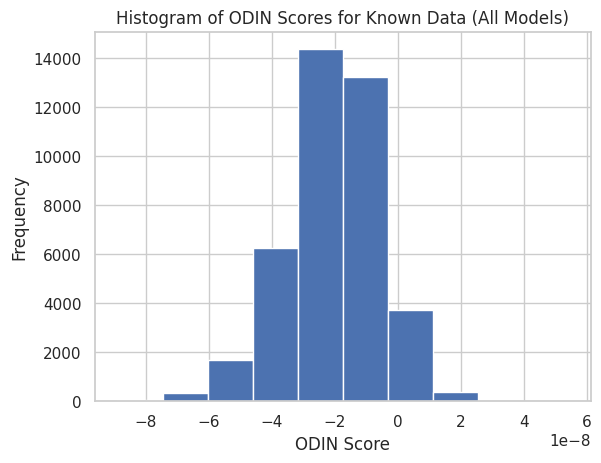

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

batch_size = 32
magnitude = 0.001
temperature = 1000
num_models = 20

loaded_models = [
    res_net01, res_net02, res_net03, res_net04, res_net05,
    res_net06, res_net07, res_net08, res_net09, res_net10,
    res_net11, res_net12, res_net13, res_net14, res_net15,
    res_net16, res_net17, res_net18, res_net19, res_net20
]

odin_scores_all_models = []

for i in range(num_models):
    logits_layer = loaded_models[i].layers[-2].output

    logits_model = tf.keras.Model(inputs=loaded_models[i].input, outputs=logits_layer)

    Known_data_X_test_as_tensor = tf.convert_to_tensor(Known_data_X_test)

    odin_scores_KNOWN = []

    for j in range(0, len(Known_data_X_test), batch_size):
        batch = Known_data_X_test_as_tensor[j:j+batch_size]

        with tf.device("/CPU:0"):
            logits = logits_model(batch)

        with tf.GradientTape() as tape:
            tape.watch(batch)
            logits = logits_model(batch)
        grads = tape.gradient(logits, batch)

        signed_grads = tf.sign(grads)

        perturbed_spectra = batch + magnitude * signed_grads

        with tf.device("/CPU:0"):
            perturbed_logits = logits_model(perturbed_spectra)

        scaled_perturbed_logits = perturbed_logits / temperature

        perturbed_softmax_output = tf.nn.softmax(scaled_perturbed_logits)

        max_perturbed_softmax_scores = tf.reduce_max(perturbed_softmax_output, axis=1)

        original_softmax_output = tf.nn.softmax(logits / temperature)
        max_softmax_scores = tf.reduce_max(original_softmax_output, axis=1)

        odin_scores_batch = max_softmax_scores - max_perturbed_softmax_scores

        odin_scores_KNOWN.extend(odin_scores_batch)

    odin_scores_KNOWN = np.array(odin_scores_KNOWN)
    odin_scores_all_models.append(odin_scores_KNOWN)

combined_odin_scores = np.concatenate(odin_scores_all_models)

plt.hist(combined_odin_scores, bins=10)

plt.xlabel('ODIN Score')
plt.ylabel('Frequency')
plt.title('Histogram of ODIN Scores for Known Data (All Models)')

plt.show()

In [ ]:
import os

folder_path = "/content/gdrive/MyDrive/Stanford_data"

file_name = "KNOWN_all_odin_scores_NAIVEKp1p2p3.txt"

file_path = os.path.join(folder_path, file_name)

with open(file_path, 'w') as file:
    for score in combined_odin_scores:
        file.write(f"{score}\n")

# Compute the OpenMax scores

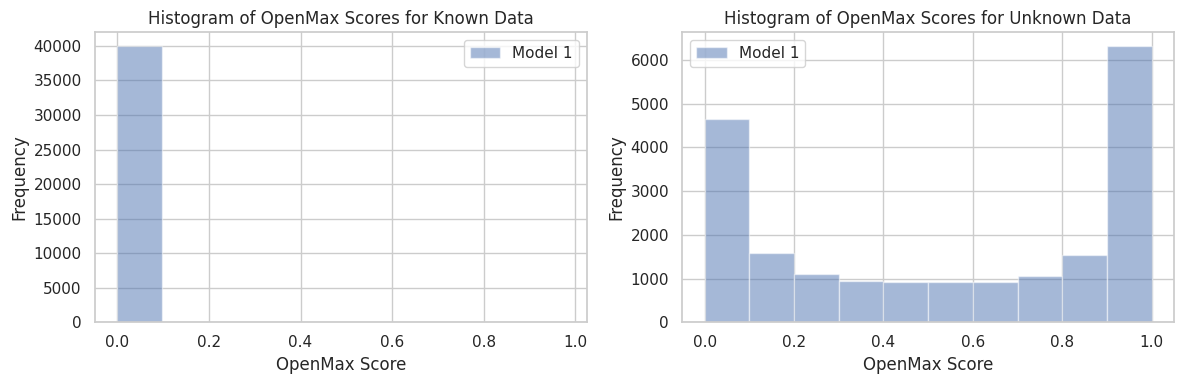

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

alpha = 1.0
num_models = 20

loaded_models = [res_net01, res_net02, res_net03, res_net04, res_net05, res_net06, res_net07, res_net08, res_net09, res_net10,
                 res_net11, res_net12, res_net13, res_net14, res_net15, res_net16, res_net17, res_net18, res_net19, res_net20]

openmax_scores_known = []
openmax_scores_unknown = []

Known_data_X_test_as_tensor = tf.convert_to_tensor(Known_data_X_test)
NeverSeen_data_X_test_as_tensor = tf.convert_to_tensor(NeverSeen_data_X_test)

for model in loaded_models:
    logits_layer = model.layers[-2].output

    logits_model = tf.keras.Model(inputs=model.input, outputs=logits_layer)

    known_logits = logits_model(Known_data_X_test_as_tensor)
    unknown_logits = logits_model(NeverSeen_data_X_test_as_tensor)

    max_known_logits = tf.reduce_max(known_logits, axis=1)
    max_unknown_logits = tf.reduce_max(unknown_logits, axis=1)

    scores_known = tf.exp(alpha * max_known_logits) / tf.reduce_sum(tf.exp(alpha * max_known_logits))

    scores_unknown = []
    for max_known, max_unknown in zip(max_known_logits, max_unknown_logits):
        unknown_score = tf.exp(alpha * max_known) / (tf.exp(alpha * max_known) + tf.exp(alpha * max_unknown))
        scores_unknown.append(unknown_score)

    openmax_scores_known.append(scores_known.numpy())
    openmax_scores_unknown.append(scores_unknown)

merged_openmax_scores_known = np.stack(openmax_scores_known, axis=1)
merged_openmax_scores_unknown = np.stack(openmax_scores_unknown, axis=1)

combined_openmax_scores_known = merged_openmax_scores_known.flatten()
combined_openmax_scores_unknown = merged_openmax_scores_unknown.flatten()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(combined_openmax_scores_known, bins=10, alpha=0.5, label=[f'Model {i+1}' for i in range(num_models)])
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Known Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(combined_openmax_scores_unknown, bins=10, alpha=0.5, label=[f'Model {i+1}' for i in range(num_models)])
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Unknown Data')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
np.savetxt('/content/gdrive/MyDrive/Stanford_data/NaiveKp1p2p3_combined_openmax_scores_known.txt', combined_openmax_scores_known)
np.savetxt('/content/gdrive/MyDrive/Stanford_data/NaiveKp1p2p3_combined_openmax_scores_unknown.txt', combined_openmax_scores_unknown)

# Compute Mahalanobis scores

32/32 [==============================] - 8s 202ms/step
Condition Number of Covariance Matrix (Known Data): 417492.6284128221
32/32 [==============================] - 7s 174ms/step
Condition Number of Covariance Matrix (Known Data): 401024.67752110766
32/32 [==============================] - 7s 174ms/step
Condition Number of Covariance Matrix (Known Data): 548955.9488767612
32/32 [==============================] - 7s 174ms/step
Condition Number of Covariance Matrix (Known Data): 467276.41792176856
32/32 [==============================] - 7s 186ms/step
Condition Number of Covariance Matrix (Known Data): 625734.1253146918
32/32 [==============================] - 7s 189ms/step
Condition Number of Covariance Matrix (Known Data): 381065.04043457675
32/32 [==============================] - 7s 182ms/step
Condition Number of Covariance Matrix (Known Data): 563430.2221475426
32/32 [==============================] - 7s 195ms/step
Condition Number of Covariance Matrix (Known Data): 463161.29049284

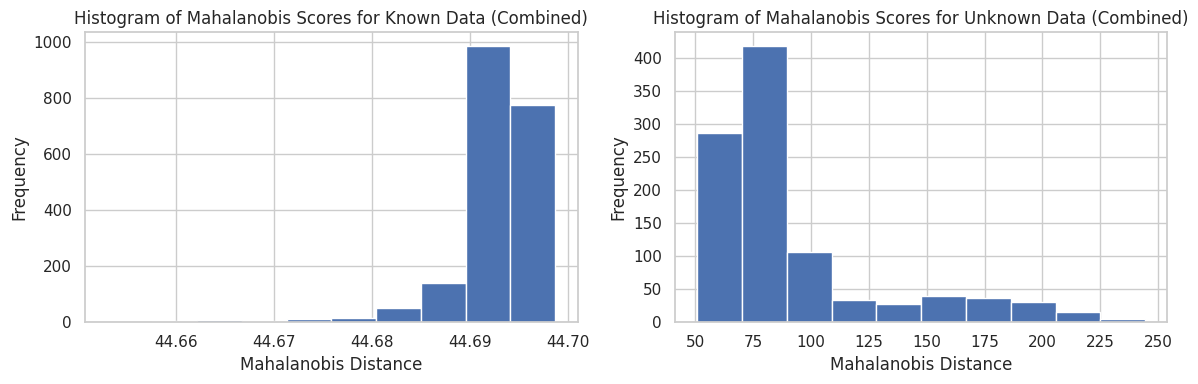

In [ ]:
import numpy as np
from scipy.spatial import distance
import tensorflow as tf
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def preprocess_data(data):
    preprocessed_data = data
    return preprocessed_data

def extract_deep_features(model, data):
    preprocessed_data = preprocess_data(data)

    deep_features = model.layers[-2].output
    deep_feature_model = tf.keras.Model(inputs=model.input, outputs=deep_features)
    extracted_features = deep_feature_model.predict(preprocessed_data)

    return extracted_features

loaded_models = [res_net01, res_net02, res_net03, res_net04, res_net05, res_net06, res_net07, res_net08, res_net09, res_net10,
                 res_net11, res_net12, res_net13, res_net14, res_net15, res_net16, res_net17, res_net18, res_net19, res_net20]

deep_features_known_all = []
mahalanobis_distances_known_all = []
deep_features_unknown_all = []
mahalanobis_distances_unknown_all = []

n_components = min(deep_features_known.shape[0], deep_features_known.shape[1]) - 1

for model in loaded_models:
    deep_features_known = extract_deep_features(model, Known_data_X_test)
    deep_features_unknown = extract_deep_features(model, NeverSeen_data_X_test)

    pca = PCA(n_components=n_components)
    deep_features_known_pca = pca.fit_transform(deep_features_known)
    deep_features_unknown_pca = pca.transform(deep_features_unknown)

    mean_known = np.mean(deep_features_known_pca, axis=0)
    cov_known = np.cov(deep_features_known_pca, rowvar=False)

    cond_number = np.linalg.cond(cov_known)
    print("Condition Number of Covariance Matrix (Known Data):", cond_number)

    epsilon = 1e-5

    if cond_number > 1 / epsilon:
        cov_known_reg = cov_known + epsilon * np.eye(cov_known.shape[0])
    else:
        cov_known_reg = cov_known

    mahalanobis_distances_known = []
    for feature in deep_features_known_pca:
        mahalanobis_distance = distance.mahalanobis(feature, mean_known, np.linalg.inv(cov_known_reg))
        mahalanobis_distances_known.append(mahalanobis_distance)

    mahalanobis_distances_unknown = []
    for feature in deep_features_unknown_pca:
        mahalanobis_distance = distance.mahalanobis(feature, mean_known, np.linalg.inv(cov_known_reg))
        mahalanobis_distances_unknown.append(mahalanobis_distance)

    deep_features_known_all.append(deep_features_known_pca)
    mahalanobis_distances_known_all.append(mahalanobis_distances_known)
    deep_features_unknown_all.append(deep_features_unknown_pca)
    mahalanobis_distances_unknown_all.append(mahalanobis_distances_unknown)

deep_features_known_combined = np.concatenate(deep_features_known_all, axis=-1)
mahalanobis_distances_known_combined = np.mean(mahalanobis_distances_known_all, axis=0)

deep_features_unknown_combined = np.concatenate(deep_features_unknown_all, axis=-1)
mahalanobis_distances_unknown_combined = np.mean(mahalanobis_distances_unknown_all, axis=0)

threshold_known = 3.0
threshold_unknown = 4.0

ood_samples_known = [i for i, distance in enumerate(mahalanobis_distances_known_combined) if distance > threshold_known]
ood_samples_unknown = [i for i, distance in enumerate(mahalanobis_distances_unknown_combined) if distance > threshold_unknown]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(mahalanobis_distances_known_combined, bins=10)
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Mahalanobis Scores for Known Data (Combined)')

plt.subplot(1, 2, 2)
plt.hist(mahalanobis_distances_unknown_combined, bins=10)
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Mahalanobis Scores for Unknown Data (Combined)')

plt.tight_layout()
plt.show()

In [ ]:
np.savetxt(f'{folder_path}/mahalanobis_distances_known_combined_Naivep1p2p3.txt', mahalanobis_distances_known_combined)
np.savetxt(f'{folder_path}/mahalanobis_distances_unknown_combined_Naivep1p2p3.txt', mahalanobis_distances_unknown_combined)

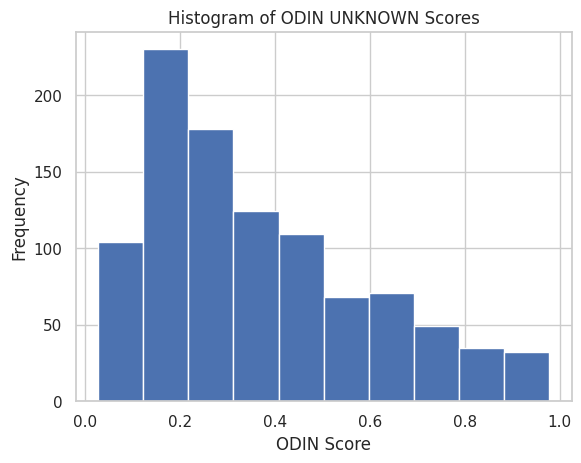

In [ ]:
plt.hist(odin_scores_for_models[0], bins=10)

plt.xlabel('ODIN Score')
plt.ylabel('Frequency')
plt.title('Histogram of ODIN UNKNOWN Scores')

plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

temperature = 1000
magnitude = 0.001
batch_size = 32
threshold = 0.1

loaded_models = [res_net01, res_net02, res_net03, res_net04, res_net05, res_net06, res_net07, res_net08, res_net09, res_net10,
                 res_net11, res_net12, res_net13, res_net14, res_net15, res_net16, res_net17, res_net18, res_net19, res_net20]


UN_Known_data_X_test_as_tensor = tf.convert_to_tensor(NeverSeen_data_X_test)

odin_scores_for_models = [np.array([]) for _ in loaded_models]

def compute_odin_scores_for_model(model, images, threshold):
    logits_layer = model.layers[-2].output
    logits_model = tf.keras.Model(inputs=model.input, outputs=logits_layer)

    odin_scores_UN_KNOWN = []

    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]

        with tf.device("/CPU:0"):
            logits = logits_model(batch)

        with tf.GradientTape() as tape:
            tape.watch(batch)
            output = logits_model(batch)
        grads = tape.gradient(output, batch)

        signed_grads = tf.sign(grads)

        perturbed_spectra = batch + magnitude * signed_grads

        with tf.device("/CPU:0"):
            perturbed_logits = logits_model(perturbed_spectra)

        scaled_perturbed_logits = perturbed_logits / temperature

        perturbed_softmax_output = tf.nn.softmax(scaled_perturbed_logits)

        max_perturbed_softmax_scores = tf.reduce_max(perturbed_softmax_output, axis=1)

        max_logits = tf.reduce_max(tf.nn.softmax(logits), axis=1)
        odin_scores_batch = max_logits - max_perturbed_softmax_scores

        odin_scores_UN_KNOWN.extend(odin_scores_batch)

    return np.array(odin_scores_UN_KNOWN)

for model_index, model in enumerate(loaded_models):
    odin_scores = compute_odin_scores_for_model(model, UN_Known_data_X_test_as_tensor, threshold)
    odin_scores_for_models[model_index] = odin_scores


# Example for 1 model

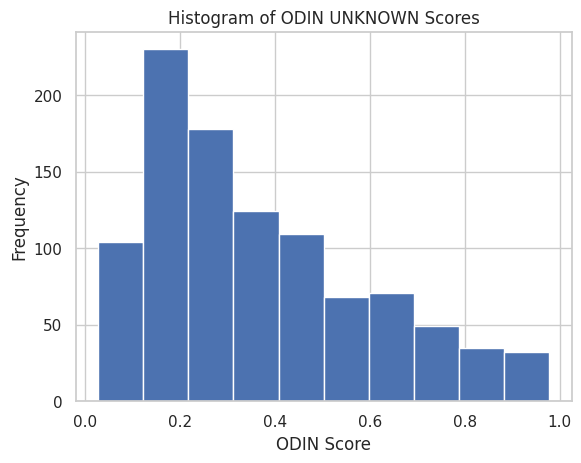

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

temperature = 1000
magnitude = 0.001

UN_Known_data_X_test_as_tensor = tf.convert_to_tensor(NeverSeen_data_X_test)

logits_layer = res_net01.layers[-2].output
logits_model = tf.keras.Model(inputs=res_net01.input, outputs=logits_layer)

odin_scores_UN_KNOWN = []

batch_size = 32

for i in range(0, len(NeverSeen_data_X_test), batch_size):
    batch = UN_Known_data_X_test_as_tensor[i:i+batch_size]

    with tf.device("/CPU:0"):
        logits = logits_model(batch)

    with tf.GradientTape() as tape:
        tape.watch(batch)
        output = logits_model(batch)
    grads = tape.gradient(output, batch)

    signed_grads = tf.sign(grads)

    perturbed_spectra = batch + magnitude * signed_grads

    with tf.device("/CPU:0"):
        perturbed_logits = logits_model(perturbed_spectra)

    scaled_perturbed_logits = perturbed_logits / temperature

    perturbed_softmax_output = tf.nn.softmax(scaled_perturbed_logits)

    max_perturbed_softmax_scores = tf.reduce_max(perturbed_softmax_output, axis=1)

    max_logits = tf.reduce_max(tf.nn.softmax(logits), axis=1)
    odin_scores_batch = max_logits - max_perturbed_softmax_scores

    odin_scores_UN_KNOWN.extend(odin_scores_batch)

odin_scores_UN_KNOWN = np.array(odin_scores_UN_KNOWN)

plt.hist(odin_scores_UN_KNOWN, bins=10)

plt.xlabel('ODIN Score')
plt.ylabel('Frequency')
plt.title('Histogram of ODIN UNKNOWN Scores')

plt.show()


In [ ]:
min(odin_scores_UN_KNOWN)

0.027194751

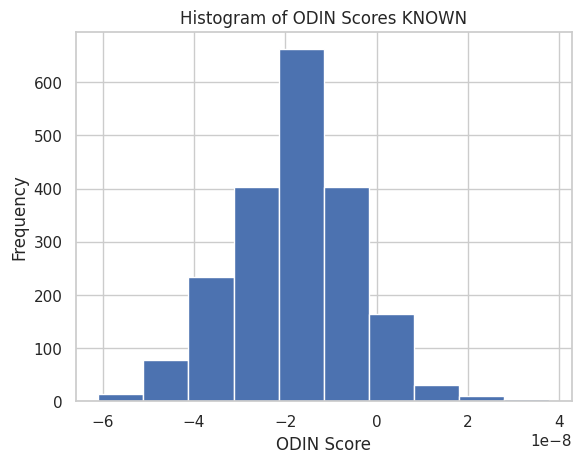

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

logits_layer = res_net01.layers[-2].output

logits_model = tf.keras.Model(inputs=res_net01.input, outputs=logits_layer)

Known_data_X_test_as_tensor = tf.convert_to_tensor(Known_data_X_test)

odin_scores_KNOWN = []

batch_size = 32
magnitude = 0.001

for i in range(0, len(Known_data_X_test), batch_size):
    batch = Known_data_X_test_as_tensor[i:i+batch_size]

    with tf.device("/CPU:0"):
        logits = logits_model(batch)

    with tf.GradientTape() as tape:
        tape.watch(batch)
        logits = logits_model(batch)
    grads = tape.gradient(logits, batch)

    signed_grads = tf.sign(grads)

    perturbed_spectra = batch + magnitude * signed_grads

    with tf.device("/CPU:0"):
        perturbed_logits = logits_model(perturbed_spectra)

    scaled_perturbed_logits = perturbed_logits / temperature

    perturbed_softmax_output = tf.nn.softmax(scaled_perturbed_logits)

    max_perturbed_softmax_scores = tf.reduce_max(perturbed_softmax_output, axis=1)

    original_softmax_output = tf.nn.softmax(logits / temperature)
    max_softmax_scores = tf.reduce_max(original_softmax_output, axis=1)

    odin_scores_batch = max_softmax_scores - max_perturbed_softmax_scores

    odin_scores_KNOWN.extend(odin_scores_batch)

odin_scores_KNOWN = np.array(odin_scores_KNOWN)
plt.hist(odin_scores_KNOWN, bins=10)

plt.xlabel('ODIN Score')
plt.ylabel('Frequency')
plt.title('Histogram of ODIN Scores KNOWN')

plt.show()

In [ ]:
max(odin_scores_KNOWN)

3.7805876e-08

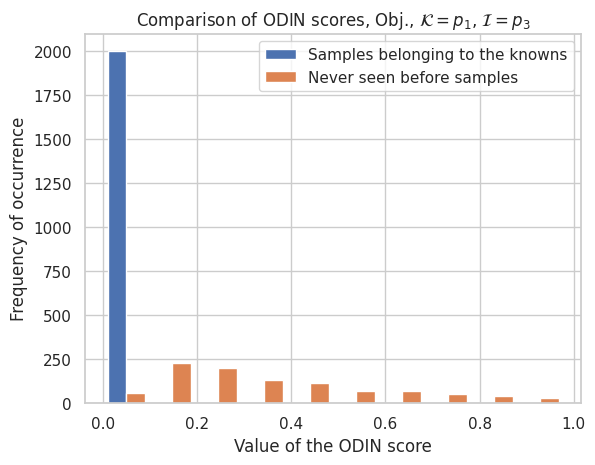

In [ ]:
plt.hist([odin_scores_KNOWN, odin_scores_UN_KNOWN], bins=10, label=['Samples belonging to the knowns', 'Never seen before samples'])  # Specify the number of bins and labels

plt.xlabel('Value of the ODIN score')
plt.ylabel('Frequency of occurrence')
plt.title('Comparison of ODIN scores, Obj., $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')

plt.legend()

plt.show()

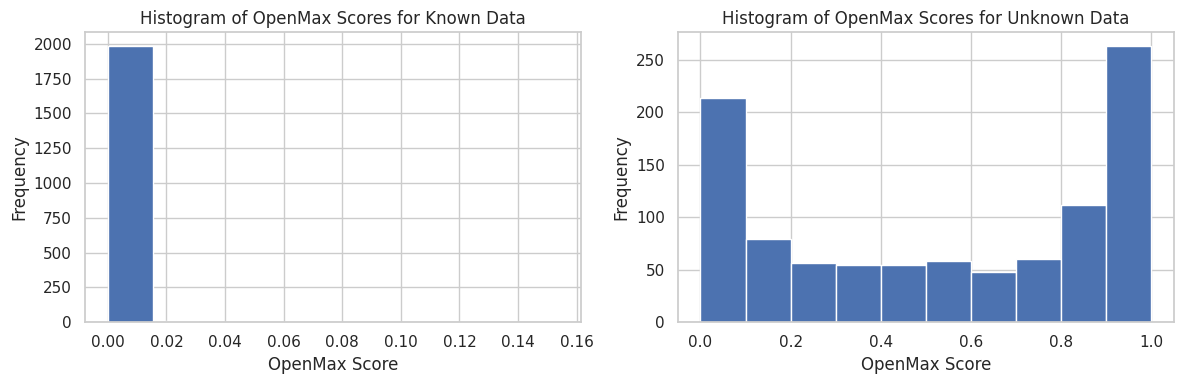

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

logits_layer = res_net01.layers[-2].output

logits_model = tf.keras.Model(inputs=res_net01.input, outputs=logits_layer)

Known_data_X_test_as_tensor = tf.convert_to_tensor(Known_data_X_test)
NeverSeen_data_X_test_as_tensor = tf.convert_to_tensor(NeverSeen_data_X_test)

known_logits = logits_model(Known_data_X_test_as_tensor)
unknown_logits = logits_model(NeverSeen_data_X_test_as_tensor)

max_known_logits = tf.reduce_max(known_logits, axis=1)
max_unknown_logits = tf.reduce_max(unknown_logits, axis=1)

def compute_openmax_scores_known(max_known_logits, alpha=1.0):
    scores_known = tf.exp(alpha * max_known_logits) / tf.reduce_sum(tf.exp(alpha * max_known_logits))
    return scores_known

openmax_scores_known = compute_openmax_scores_known(max_known_logits)

def compute_openmax_scores_unknown(max_known_logits, max_unknown_logits, alpha=1.0):
    scores_unknown = []
    for max_known, max_unknown in zip(max_known_logits, max_unknown_logits):
        unknown_score = tf.exp(alpha * max_known) / (tf.exp(alpha * max_known) + tf.exp(alpha * max_unknown))
        scores_unknown.append(unknown_score)
    return tf.stack(scores_unknown)

openmax_scores_unknown = compute_openmax_scores_unknown(max_known_logits, max_unknown_logits)

openmax_scores_known = openmax_scores_known.numpy()
openmax_scores_unknown = openmax_scores_unknown.numpy()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(openmax_scores_known, bins=10)
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Known Data')

plt.subplot(1, 2, 2)
plt.hist(openmax_scores_unknown, bins=10)
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Unknown Data')

plt.tight_layout()
plt.show()

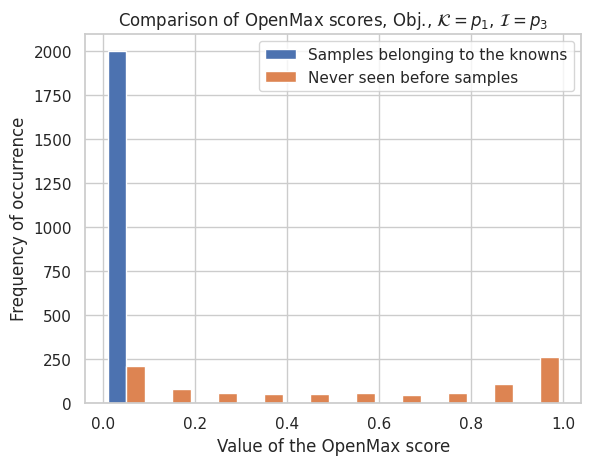

In [ ]:
plt.hist([openmax_scores_known, openmax_scores_unknown], bins=10, label=['Samples belonging to the knowns', 'Never seen before samples'])  # Specify the number of bins and labels

plt.xlabel('Value of the OpenMax score')
plt.ylabel('Frequency of occurrence')
plt.title('Comparison of OpenMax scores, Obj., $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')

plt.legend()

plt.show()

In [ ]:
max(openmax_scores_known)

0.15391746

In [ ]:
min(openmax_scores_unknown)

7.39529e-05

In [ ]:
import numpy as np

openmax_scores_known_sorted = np.sort(openmax_scores_known)
openmax_scores_unknown_sorted = np.sort(openmax_scores_unknown)

min_known_score = openmax_scores_known_sorted.min()
max_known_score = openmax_scores_known_sorted.max()
min_unknown_score = openmax_scores_unknown_sorted.min()
max_unknown_score = openmax_scores_unknown_sorted.max()

bins = np.linspace(min(min_known_score, min_unknown_score), max(max_known_score, max_unknown_score), 1000)

hist_known, _ = np.histogram(openmax_scores_known_sorted, bins)
hist_unknown, _ = np.histogram(openmax_scores_unknown_sorted, bins)

intersection = np.minimum(hist_known, hist_unknown)
union = np.maximum(hist_known, hist_unknown)

iou = np.sum(intersection) / np.sum(union) * 100

print(f"Overlap (IoU): {iou:.2f}%")

Overlap (IoU): 2.42%


In [ ]:
def preprocess_data(data):
    preprocessed_data = data
    return preprocessed_data


In [ ]:
import numpy as np
from scipy.spatial import distance
import tensorflow as tf

def preprocess_data(data):
    preprocessed_data = data
    return preprocessed_data

def extract_deep_features(model, data):

    preprocessed_data = preprocess_data(data)

    deep_features = model.layers[-2].output
    deep_feature_model = tf.keras.Model(inputs=model.input, outputs=deep_features)
    extracted_features = deep_feature_model.predict(preprocessed_data)

    return extracted_features

deep_features_known = extract_deep_features(res_net01, Known_data_X_test)
deep_features_unknown = extract_deep_features(res_net01, NeverSeen_data_X_test)

mean_known = np.mean(deep_features_known, axis=0)
cov_known = np.cov(deep_features_known, rowvar=False)

cond_number = np.linalg.cond(cov_known)
print("Condition Number of Covariance Matrix (Known Data):", cond_number)

epsilon = 1e-6

if cond_number > 1 / epsilon:
    cov_known_reg = cov_known + epsilon * np.eye(cov_known.shape[0])
else:
    cov_known_reg = cov_known

mahalanobis_distances_known = []
for feature in deep_features_known:
    mahalanobis_distance = distance.mahalanobis(feature, mean_known, np.linalg.inv(cov_known_reg))
    mahalanobis_distances_known.append(mahalanobis_distance)

mahalanobis_distances_unknown = []
for feature in deep_features_unknown:
    mahalanobis_distance = distance.mahalanobis(feature, mean_known, np.linalg.inv(cov_known_reg))
    mahalanobis_distances_unknown.append(mahalanobis_distance)

threshold_known = 3.0
threshold_unknown = 4.0
ood_samples_known = [i for i, distance in enumerate(mahalanobis_distances_known) if distance > threshold_known]
ood_samples_unknown = [i for i, distance in enumerate(mahalanobis_distances_unknown) if distance > threshold_unknown]

print("Out-of-Distribution Sample Indices (Known Data):", ood_samples_known)
print("Out-of-Distribution Sample Indices (Unknown Data):", ood_samples_unknown)

32/32 [==============================] - 6s 169ms/step
Condition Number of Covariance Matrix (Known Data): 2.4366023256507043e+22


KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(mahalanobis_distances_known, bins=10)
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Known Data')

plt.subplot(1, 2, 2)
plt.hist(mahalanobis_distances_unknown, bins=10)
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Unknown Data')

plt.tight_layout()
plt.show()

In [ ]:
plt.hist([mahalanobis_distances_known, mahalanobis_distances_unknown], bins=25, label=['Samples belonging to the knowns', 'Never seen before samples'])  # Specify the number of bins and labels
plt.xlim(2.5, 15)

plt.xlabel('Value of the Mahalanobis score')
plt.ylabel('Frequency of occurrence')
plt.title('Comparison of Mahalanobis scores, Obj., $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')

plt.legend()

plt.show()

In [ ]:
import numpy as np

mahalanobis_scores_known_sorted = np.sort(mahalanobis_distances_known)
mahalanobis_scores_unknown_sorted = np.sort(mahalanobis_distances_unknown)

min_known_score = mahalanobis_scores_known_sorted.min()
max_known_score = mahalanobis_scores_known_sorted.max()
min_unknown_score = mahalanobis_scores_unknown_sorted.min()
max_unknown_score = mahalanobis_scores_unknown_sorted.max()

bins = np.linspace(min(min_known_score, min_unknown_score), max(max_known_score, max_unknown_score), 1000)

hist_known, _ = np.histogram(mahalanobis_scores_known_sorted, bins)
hist_unknown, _ = np.histogram(mahalanobis_scores_unknown_sorted, bins)

intersection = np.minimum(hist_known, hist_unknown)
union = np.maximum(hist_known, hist_unknown)

iou = np.sum(intersection) / np.sum(union) * 100

print(f"Overlap (IoU): {iou:.2f}%")

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(8, 12))

axs[0].hist([odin_scores_KNOWN, odin_scores_UN_KNOWN], bins=10, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[0].set_xlabel('Value of the ODIN score')
axs[0].set_ylabel('Frequency of occurrence')
axs[0].set_title('Comparison of ODIN scores, Obj., $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[0].legend()

axs[1].hist([openmax_scores_known, openmax_scores_unknown], bins=10, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[1].set_xlabel('Value of the OpenMax score')
axs[1].set_ylabel('Frequency of occurrence')
axs[1].set_title('Comparison of OpenMax scores, Obj., $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[1].legend()

axs[2].hist([mahalanobis_distances_known, mahalanobis_distances_unknown], bins=25, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[2].set_xlabel('Value of the Mahalanobis score')
axs[2].set_ylabel('Frequency of occurrence')
axs[2].set_title('Comparison of Mahalanobis scores, Obj., $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[2].legend()

plt.tight_layout()

plt.show()


In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].hist([odin_scores_KNOWN, odin_scores_UN_KNOWN], bins=10, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[0].set_xlabel('Value of the ODIN score')
axs[0].set_ylabel('Frequency of occurrence')
axs[0].set_title('Comparison of ODIN scores, Obj.class, $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[0].legend()

axs[1].hist([openmax_scores_known, openmax_scores_unknown], bins=10, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[1].set_xlabel('Value of the OpenMax score')
axs[1].set_ylabel('Frequency of occurrence')
axs[1].set_title('Comparison of OpenMax scores, Obj., $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[1].legend()

axs[2].hist([mahalanobis_distances_known, mahalanobis_distances_unknown], bins=25, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[2].set_xlabel('Value of the Mahalanobis score')
axs[2].set_ylabel('Frequency of occurrence')
axs[2].set_title('Comparison of Mahalanobis scores, Obj., $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[2].legend()

plt.tight_layout()

plt.show()


# Separating $\mathcal{K}$ and $\mathcal{N}$ by a fixed (class-independendent) threshold

In [ ]:
prediction_known = prediction_known_ensemble_1
prediction_unknown = prediction_unknown_ensemble_1

In [ ]:
def thresholding(threshold):
  true = 0
  for i in range(prediction_known.shape[0]):
    if prediction_known.argmax(axis=1)[i] == Known_data_X_test_label_int[i] and max(prediction_known[i]) > threshold:
      true += 1
  return true/(prediction_known.shape[0])

In [ ]:
CorrectThresholding = []
for i in range(90):
  CorrectThresholding.append([0.1 + 0.01*i,100*thresholding(0.1 + 0.01*i)])
for i in range(10):
  CorrectThresholding.append([0.99 + 0.001*i,100*thresholding(0.99 + 0.001*i)])
CorrectThresholding

[[0.1, 88.85],
 [0.11, 88.85],
 [0.12000000000000001, 88.85],
 [0.13, 88.85],
 [0.14, 88.85],
 [0.15000000000000002, 88.85],
 [0.16, 88.85],
 [0.17, 88.85],
 [0.18, 88.85],
 [0.19, 88.85],
 [0.2, 88.85],
 [0.21000000000000002, 88.8],
 [0.22, 88.8],
 [0.23, 88.8],
 [0.24000000000000002, 88.8],
 [0.25, 88.8],
 [0.26, 88.8],
 [0.27, 88.8],
 [0.28, 88.8],
 [0.29000000000000004, 88.8],
 [0.30000000000000004, 88.8],
 [0.31, 88.8],
 [0.32, 88.8],
 [0.33, 88.8],
 [0.33999999999999997, 88.8],
 [0.35, 88.8],
 [0.36, 88.8],
 [0.37, 88.8],
 [0.38, 88.8],
 [0.39, 88.8],
 [0.4, 88.75],
 [0.41000000000000003, 88.75],
 [0.42000000000000004, 88.75],
 [0.43000000000000005, 88.7],
 [0.44000000000000006, 88.6],
 [0.45000000000000007, 88.6],
 [0.45999999999999996, 88.6],
 [0.47, 88.5],
 [0.48, 88.4],
 [0.49, 88.3],
 [0.5, 88.25],
 [0.51, 88.25],
 [0.52, 88.2],
 [0.53, 87.9],
 [0.54, 87.85],
 [0.55, 87.6],
 [0.56, 87.25],
 [0.5700000000000001, 87.15],
 [0.58, 86.95],
 [0.59, 86.8],
 [0.6, 86.45],
 [0.61, 86

In [ ]:
def false_identify(threshold):
  false_identify = 0
  for i in range(prediction_known.shape[0]):
    if prediction_known.argmax(axis=1)[i] != Known_data_X_test_label_int[i] and max(prediction_known[i]) > threshold:
      false_identify += 1
  return false_identify/(prediction_known.shape[0])

In [ ]:
FalseIdentify = []
for i in range(90):
  FalseIdentify.append([0.1 + 0.01*i,100*false_identify(0.1 + 0.01*i)])
for i in range(10):
  FalseIdentify.append([0.99 + 0.001*i,100*false_identify(0.99 + 0.001*i)])
FalseIdentify

[[0.1, 11.15],
 [0.11, 11.15],
 [0.12000000000000001, 11.15],
 [0.13, 11.15],
 [0.14, 11.15],
 [0.15000000000000002, 11.15],
 [0.16, 11.15],
 [0.17, 11.15],
 [0.18, 11.15],
 [0.19, 11.15],
 [0.2, 11.15],
 [0.21000000000000002, 11.15],
 [0.22, 11.15],
 [0.23, 11.15],
 [0.24000000000000002, 11.15],
 [0.25, 11.15],
 [0.26, 11.15],
 [0.27, 11.1],
 [0.28, 11.1],
 [0.29000000000000004, 11.1],
 [0.30000000000000004, 11.1],
 [0.31, 11.1],
 [0.32, 11.1],
 [0.33, 11.0],
 [0.33999999999999997, 10.9],
 [0.35, 10.7],
 [0.36, 10.65],
 [0.37, 10.6],
 [0.38, 10.5],
 [0.39, 10.4],
 [0.4, 10.299999999999999],
 [0.41000000000000003, 10.299999999999999],
 [0.42000000000000004, 10.15],
 [0.43000000000000005, 10.0],
 [0.44000000000000006, 9.85],
 [0.45000000000000007, 9.85],
 [0.45999999999999996, 9.85],
 [0.47, 9.85],
 [0.48, 9.75],
 [0.49, 9.75],
 [0.5, 9.65],
 [0.51, 9.55],
 [0.52, 9.4],
 [0.53, 9.2],
 [0.54, 9.049999999999999],
 [0.55, 8.95],
 [0.56, 8.649999999999999],
 [0.5700000000000001, 8.55],
 [0.

In [ ]:
def misclassifyunknown(threshold):
  misclassifyunknown = 0
  for i in range(prediction_unknown.shape[0]):
    if max(prediction_unknown[i]) > threshold:
      misclassifyunknown += 1
  return misclassifyunknown/(prediction_unknown.shape[0])

In [ ]:
UnknownMisclassify = []
for i in range(90):
  UnknownMisclassify.append([0.1 + 0.01*i,100*misclassifyunknown(0.1 + 0.01*i)])
for i in range(10):
  UnknownMisclassify.append([0.99 + 0.001*i,100*misclassifyunknown(0.99 + 0.001*i)])
UnknownMisclassify

[[0.1, 100.0],
 [0.11, 100.0],
 [0.12000000000000001, 100.0],
 [0.13, 100.0],
 [0.14, 100.0],
 [0.15000000000000002, 100.0],
 [0.16, 100.0],
 [0.17, 100.0],
 [0.18, 100.0],
 [0.19, 100.0],
 [0.2, 100.0],
 [0.21000000000000002, 100.0],
 [0.22, 100.0],
 [0.23, 100.0],
 [0.24000000000000002, 100.0],
 [0.25, 100.0],
 [0.26, 100.0],
 [0.27, 100.0],
 [0.28, 100.0],
 [0.29000000000000004, 100.0],
 [0.30000000000000004, 99.8],
 [0.31, 99.8],
 [0.32, 99.8],
 [0.33, 99.7],
 [0.33999999999999997, 99.6],
 [0.35, 99.5],
 [0.36, 99.4],
 [0.37, 99.4],
 [0.38, 98.9],
 [0.39, 98.6],
 [0.4, 98.4],
 [0.41000000000000003, 98.3],
 [0.42000000000000004, 98.1],
 [0.43000000000000005, 97.89999999999999],
 [0.44000000000000006, 97.89999999999999],
 [0.45000000000000007, 97.2],
 [0.45999999999999996, 96.89999999999999],
 [0.47, 96.6],
 [0.48, 96.5],
 [0.49, 95.89999999999999],
 [0.5, 95.5],
 [0.51, 94.19999999999999],
 [0.52, 92.9],
 [0.53, 92.2],
 [0.54, 91.10000000000001],
 [0.55, 90.60000000000001],
 [0.56, 

In [ ]:
def dontknow(threshold):
  notknown = 0
  for i in range(prediction_known.shape[0]):
    if max(prediction_known[i]) <= threshold:
      notknown += 1
  return notknown/(prediction_known.shape[0])

In [ ]:
DontKnowThresholding = []
for i in range(90):
  DontKnowThresholding.append([0.1 + 0.01*i,100*dontknow(0.1 + 0.01*i)])
for i in range(10):
  DontKnowThresholding.append([0.99 + 0.001*i,100*dontknow(0.99 + 0.001*i)])
DontKnowThresholding

[[0.1, 0.0],
 [0.11, 0.0],
 [0.12000000000000001, 0.0],
 [0.13, 0.0],
 [0.14, 0.0],
 [0.15000000000000002, 0.0],
 [0.16, 0.0],
 [0.17, 0.0],
 [0.18, 0.0],
 [0.19, 0.0],
 [0.2, 0.0],
 [0.21000000000000002, 0.05],
 [0.22, 0.05],
 [0.23, 0.05],
 [0.24000000000000002, 0.05],
 [0.25, 0.05],
 [0.26, 0.05],
 [0.27, 0.1],
 [0.28, 0.1],
 [0.29000000000000004, 0.1],
 [0.30000000000000004, 0.1],
 [0.31, 0.1],
 [0.32, 0.1],
 [0.33, 0.2],
 [0.33999999999999997, 0.3],
 [0.35, 0.5],
 [0.36, 0.5499999999999999],
 [0.37, 0.6],
 [0.38, 0.7000000000000001],
 [0.39, 0.8],
 [0.4, 0.95],
 [0.41000000000000003, 0.95],
 [0.42000000000000004, 1.0999999999999999],
 [0.43000000000000005, 1.3],
 [0.44000000000000006, 1.55],
 [0.45000000000000007, 1.55],
 [0.45999999999999996, 1.55],
 [0.47, 1.6500000000000001],
 [0.48, 1.8499999999999999],
 [0.49, 1.95],
 [0.5, 2.1],
 [0.51, 2.1999999999999997],
 [0.52, 2.4],
 [0.53, 2.9000000000000004],
 [0.54, 3.1],
 [0.55, 3.45],
 [0.56, 4.1000000000000005],
 [0.57000000000000

In [ ]:
aligned_array = [element for row in prediction_unknown for element in row]
max_value = max(aligned_array)

print("The maximum value in the aligned array is:", max_value)


The maximum value in the aligned array is: 0.9999999


In [ ]:
thresholding(max_value)

0.0

In [ ]:
dontknow(max_value)

1.0

In [ ]:
misclassifyunknown(max_value)

0.0

In [ ]:
false_identify(max_value)

0.0

In [ ]:
DontKnowThresholdingANOTHER = []

for i in range(89):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.1 + 0.01*i),100*dontknow(0.1 + 0.01*i),])

for i in range(10):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.99 + 0.001*i),100*dontknow(0.99 + 0.001*i),])

for i in range(10):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.999 + 0.0001*i),100*dontknow(0.999 + 0.0001*i),])

for i in range(10):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.9999 + 0.00001*i),100*dontknow(0.9999 + 0.00001*i),])

for i in range(10):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.99999 + 0.000001*i),100*dontknow(0.99999 + 0.000001*i),])

for i in range(10):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.999999 + 0.0000001*i),100*dontknow(0.999999 + 0.0000001*i),])

for i in range(9):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.9999999 + 0.00000001*i),100*dontknow(0.9999999 + 0.00000001*i),])

DontKnowThresholdingANOTHER.append([100*thresholding(max_value),100*dontknow(max_value)])

DontKnowThresholdingANOTHER

[[88.85, 0.0],
 [88.85, 0.0],
 [88.85, 0.0],
 [88.85, 0.0],
 [88.85, 0.0],
 [88.85, 0.0],
 [88.85, 0.0],
 [88.85, 0.0],
 [88.85, 0.0],
 [88.85, 0.0],
 [88.85, 0.0],
 [88.8, 0.05],
 [88.8, 0.05],
 [88.8, 0.05],
 [88.8, 0.05],
 [88.8, 0.05],
 [88.8, 0.05],
 [88.8, 0.1],
 [88.8, 0.1],
 [88.8, 0.1],
 [88.8, 0.1],
 [88.8, 0.1],
 [88.8, 0.1],
 [88.8, 0.2],
 [88.8, 0.3],
 [88.8, 0.5],
 [88.8, 0.5499999999999999],
 [88.8, 0.6],
 [88.8, 0.7000000000000001],
 [88.8, 0.8],
 [88.75, 0.95],
 [88.75, 0.95],
 [88.75, 1.0999999999999999],
 [88.7, 1.3],
 [88.6, 1.55],
 [88.6, 1.55],
 [88.6, 1.55],
 [88.5, 1.6500000000000001],
 [88.4, 1.8499999999999999],
 [88.3, 1.95],
 [88.25, 2.1],
 [88.25, 2.1999999999999997],
 [88.2, 2.4],
 [87.9, 2.9000000000000004],
 [87.85, 3.1],
 [87.6, 3.45],
 [87.25, 4.1000000000000005],
 [87.15, 4.3],
 [86.95, 4.65],
 [86.8, 4.9],
 [86.45, 5.45],
 [86.3, 5.75],
 [86.1, 6.1],
 [85.95, 6.35],
 [85.9, 6.550000000000001],
 [85.65, 6.9],
 [85.45, 7.249999999999999],
 [85.35000000

In [ ]:
UnknownMisclassifyANOTHER = []
for i in range(89):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.1 + 0.01*i),100*misclassifyunknown(0.1 + 0.01*i),])
for i in range(10):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.99 + 0.001*i),100*misclassifyunknown(0.99 + 0.001*i),])

for i in range(10):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.999 + 0.0001*i),100*misclassifyunknown(0.999 + 0.0001*i),])

for i in range(10):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.9999 + 0.00001*i),100*misclassifyunknown(0.9999 + 0.00001*i),])

for i in range(10):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.99999 + 0.000001*i),100*misclassifyunknown(0.99999 + 0.000001*i),])

for i in range(10):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.999999 + 0.0000001*i),100*misclassifyunknown(0.999999 + 0.0000001*i),])

for i in range(9):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.9999999 + 0.00000001*i),100*misclassifyunknown(0.9999999 + 0.00000001*i),])

UnknownMisclassifyANOTHER.append([100*thresholding(max_value),100*misclassifyunknown(max_value),])

UnknownMisclassifyANOTHER

[[88.85, 100.0],
 [88.85, 100.0],
 [88.85, 100.0],
 [88.85, 100.0],
 [88.85, 100.0],
 [88.85, 100.0],
 [88.85, 100.0],
 [88.85, 100.0],
 [88.85, 100.0],
 [88.85, 100.0],
 [88.85, 100.0],
 [88.8, 100.0],
 [88.8, 100.0],
 [88.8, 100.0],
 [88.8, 100.0],
 [88.8, 100.0],
 [88.8, 100.0],
 [88.8, 100.0],
 [88.8, 100.0],
 [88.8, 100.0],
 [88.8, 99.8],
 [88.8, 99.8],
 [88.8, 99.8],
 [88.8, 99.7],
 [88.8, 99.6],
 [88.8, 99.5],
 [88.8, 99.4],
 [88.8, 99.4],
 [88.8, 98.9],
 [88.8, 98.6],
 [88.75, 98.4],
 [88.75, 98.3],
 [88.75, 98.1],
 [88.7, 97.89999999999999],
 [88.6, 97.89999999999999],
 [88.6, 97.2],
 [88.6, 96.89999999999999],
 [88.5, 96.6],
 [88.4, 96.5],
 [88.3, 95.89999999999999],
 [88.25, 95.5],
 [88.25, 94.19999999999999],
 [88.2, 92.9],
 [87.9, 92.2],
 [87.85, 91.10000000000001],
 [87.6, 90.60000000000001],
 [87.25, 89.60000000000001],
 [87.15, 88.4],
 [86.95, 87.3],
 [86.8, 85.9],
 [86.45, 84.3],
 [86.3, 83.39999999999999],
 [86.1, 82.8],
 [85.95, 81.5],
 [85.9, 80.9],
 [85.65, 80.3000

In [ ]:
FalseIdentifyANOTHER = []
for i in range(89):
  FalseIdentifyANOTHER.append([100*thresholding(0.1 + 0.01*i),100*false_identify(0.1 + 0.01*i),])
for i in range(10):
  FalseIdentifyANOTHER.append([100*thresholding(0.99 + 0.001*i),100*false_identify(0.99 + 0.001*i)])

for i in range(10):
  FalseIdentifyANOTHER.append([100*thresholding(0.999 + 0.0001*i),100*false_identify(0.999 + 0.0001*i),])

for i in range(10):
  FalseIdentifyANOTHER.append([100*thresholding(0.9999 + 0.00001*i),100*false_identify(0.9999 + 0.00001*i),])

for i in range(10):
  FalseIdentifyANOTHER.append([100*thresholding(0.99999 + 0.000001*i),100*false_identify(0.99999 + 0.000001*i),])

for i in range(10):
  FalseIdentifyANOTHER.append([100*thresholding(0.999999 + 0.0000001*i),100*false_identify(0.999999 + 0.0000001*i),])

for i in range(9):
  FalseIdentifyANOTHER.append([100*thresholding(0.9999999 + 0.00000001*i),100*false_identify(0.9999999 + 0.00000001*i),])

FalseIdentifyANOTHER.append([100*thresholding(max_value),100*false_identify(max_value),])
FalseIdentifyANOTHER

[[88.85, 11.15],
 [88.85, 11.15],
 [88.85, 11.15],
 [88.85, 11.15],
 [88.85, 11.15],
 [88.85, 11.15],
 [88.85, 11.15],
 [88.85, 11.15],
 [88.85, 11.15],
 [88.85, 11.15],
 [88.85, 11.15],
 [88.8, 11.15],
 [88.8, 11.15],
 [88.8, 11.15],
 [88.8, 11.15],
 [88.8, 11.15],
 [88.8, 11.15],
 [88.8, 11.1],
 [88.8, 11.1],
 [88.8, 11.1],
 [88.8, 11.1],
 [88.8, 11.1],
 [88.8, 11.1],
 [88.8, 11.0],
 [88.8, 10.9],
 [88.8, 10.7],
 [88.8, 10.65],
 [88.8, 10.6],
 [88.8, 10.5],
 [88.8, 10.4],
 [88.75, 10.299999999999999],
 [88.75, 10.299999999999999],
 [88.75, 10.15],
 [88.7, 10.0],
 [88.6, 9.85],
 [88.6, 9.85],
 [88.6, 9.85],
 [88.5, 9.85],
 [88.4, 9.75],
 [88.3, 9.75],
 [88.25, 9.65],
 [88.25, 9.55],
 [88.2, 9.4],
 [87.9, 9.2],
 [87.85, 9.049999999999999],
 [87.6, 8.95],
 [87.25, 8.649999999999999],
 [87.15, 8.55],
 [86.95, 8.4],
 [86.8, 8.3],
 [86.45, 8.1],
 [86.3, 7.95],
 [86.1, 7.8],
 [85.95, 7.7],
 [85.9, 7.55],
 [85.65, 7.449999999999999],
 [85.45, 7.3],
 [85.35000000000001, 7.249999999999999],
 [

# Class-adaptive threshold

# Run #1

In [ ]:
prediction_known = prediction_known_ensemble_1
prediction_unknown = prediction_unknown_ensemble_1

In [ ]:
ThresholdNeverSeenBefores = []
for i in range(20):
  ThresholdNeverSeenBefores.append(np.max(prediction_unknown[:,i]))

In [ ]:
ThresholdNeverSeenBefores

[0.9999999,
 0.99993837,
 0.99997413,
 0.99955,
 0.9849764,
 0.13415858,
 0.9520093,
 0.99966794,
 0.008279827,
 0.31542295,
 0.5280966,
 0.00026533083,
 0.99766034,
 0.99993134,
 0.9845427,
 0.999987,
 0.20938723,
 0.00022063241,
 0.7811894,
 0.90735114]

In [ ]:
C_count0 = 0
for i in range(100):
  if prediction_known[i,0] > ThresholdNeverSeenBefores[0] and np.argmax(prediction_known[i]) == 0:
    C_count0 += 1
  else:
    C_count0 += 0
C_count0

0

In [ ]:
mistake0 = 0
for i in range(100):
  if np.argmax(prediction_known[i]) != 0 and max(prediction_known[i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[i])]:
    mistake0 += 1
    print(i)
  else:
    mistake0 += 0
mistake0
print("Number of mistakes in this class:",mistake0)

Number of mistakes in this class: 0


In [ ]:
C_count1 = 0
for i in range(100):
  if prediction_known[100 + i,1] > ThresholdNeverSeenBefores[1] and np.argmax(prediction_known[100 + i]) == 1:
    C_count1 += 1
  else:
    C_count1 += 0
C_count1

3

In [ ]:
mistake1 = 0
for i in range(100):
  if np.argmax(prediction_known[100 + i]) != 1 and max(prediction_known[100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[100 + i])]:
    mistake1 += 1
    print(100 + i)
  else:
    mistake1 += 0
mistake1
print("Number of mistakes in this class:",mistake1)

117
Number of mistakes in this class: 1


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[117])] = max(prediction_known[117])

In [ ]:
mistake1 = 0
for i in range(100):
  if np.argmax(prediction_known[100 + i]) != 1 and max(prediction_known[100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[100 + i])]:
    mistake1 += 1
    print(100 + i)
  else:
    mistake1 += 0
mistake1
print("Number of mistakes in this class:",mistake1)

Number of mistakes in this class: 0


In [ ]:
C_count2 = 0
for i in range(100):
  if prediction_known[200 + i,2] > ThresholdNeverSeenBefores[2] and np.argmax(prediction_known[200 + i]) == 2:
    C_count2 += 1
  else:
    C_count2 += 0
C_count2

10

In [ ]:
mistake2 = 0
for i in range(100):
  if np.argmax(prediction_known[200 + i]) != 2 and max(prediction_known[200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[200 + i])]:
    mistake2 += 1
    print(200 + i)
  else:
    mistake2 += 0
mistake2
print("Number of mistakes in this class:",mistake2)

Number of mistakes in this class: 0


In [ ]:
C_count3 = 0
for i in range(100):
  if prediction_known[300 + i,3] > ThresholdNeverSeenBefores[3] and np.argmax(prediction_known[300 + i]) == 3:
    C_count3 += 1
  else:
    C_count3 += 0
C_count3

38

In [ ]:
mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0
mistake3
print("Number of mistakes in this class:",mistake3)

306
344
Number of mistakes in this class: 2


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[344])] = max(prediction_known[344])

In [ ]:
mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0
mistake3
print("Number of mistakes in this class:",mistake3)

Number of mistakes in this class: 0


In [ ]:
C_count4 = 0
for i in range(100):
  if prediction_known[400 + i,4] > ThresholdNeverSeenBefores[4] and np.argmax(prediction_known[400 + i]) == 4:
    C_count4 += 1
  else:
    C_count4 += 0
C_count4

10

In [ ]:
mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0
print("Number of mistakes in this class:",mistake4)

416
418
442
Number of mistakes in this class: 3


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[442])] = max(prediction_known[442])

In [ ]:
mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0
print("Number of mistakes in this class:",mistake4)

Number of mistakes in this class: 0


In [ ]:
C_count5 = 0
for i in range(100):
  if prediction_known[500 + i,5] > ThresholdNeverSeenBefores[5] and np.argmax(prediction_known[500 + i]) == 5:
    C_count5 += 1
  else:
    C_count5 += 0
C_count5

99

In [ ]:
mistake5 = 0
for i in range(100):
  if np.argmax(prediction_known[500 + i]) != 5 and max(prediction_known[500 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[500 + i])]:
    mistake5 += 1
    print(500 + i)
  else:
    mistake5 += 0
print("Number of mistakes in this class:",mistake5)

Number of mistakes in this class: 0


In [ ]:
C_count6 = 0
for i in range(100):
  if prediction_known[600 + i,6] > ThresholdNeverSeenBefores[6] and np.argmax(prediction_known[600 + i]) == 6:
    C_count6 += 1
  else:
    C_count6 += 0
C_count6

60

In [ ]:
mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0
print("Number of mistakes in this class:",mistake6)

602
603
604
607
608
616
618
619
620
623
624
628
630
651
657
661
665
697
699
Number of mistakes in this class: 19


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[699])] = max(prediction_known[699])

In [ ]:
mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0
print("Number of mistakes in this class:",mistake6)

Number of mistakes in this class: 0


In [ ]:
C_count7 = 0
for i in range(100):
  if prediction_known[700 + i,7] > ThresholdNeverSeenBefores[7]  and np.argmax(prediction_known[700 + i]) == 7:
    C_count7 += 1
  else:
    C_count7 += 0
C_count7

74

In [ ]:
mistake7 = 0
for i in range(100):
  if np.argmax(prediction_known[700 + i]) != 7 and max(prediction_known[700 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[700 + i])]:
    mistake7 += 1
    print(700 + i)
  else:
    mistake7 += 0
print("Number of mistakes in this class:",mistake7)

Number of mistakes in this class: 0


In [ ]:
C_count8 = 0
for i in range(100):
  if prediction_known[800 + i,8] > ThresholdNeverSeenBefores[8] and np.argmax(prediction_known[800 + i]) == 8:
    C_count8 += 1
  else:
    C_count8 += 0
C_count8

84

In [ ]:
mistake8 = 0
for i in range(100):
  if np.argmax(prediction_known[800 + i]) != 8 and max(prediction_known[800 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[800 + i])]:
    mistake8 += 1
    print(800 + i)
  else:
    mistake8 += 0
print("Number of mistakes in this class:",mistake8)

801
809
815
818
824
826
832
833
835
840
853
859
865
870
872
879
Number of mistakes in this class: 16


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[853])] = max(prediction_known[853])

In [ ]:
mistake8 = 0
for i in range(100):
  if np.argmax(prediction_known[800 + i]) != 8 and max(prediction_known[800 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[800 + i])]:
    mistake8 += 1
    print(800 + i)
  else:
    mistake8 += 0
print("Number of mistakes in this class:",mistake8)

Number of mistakes in this class: 0


In [ ]:
C_count9 = 0
for i in range(100):
  if prediction_known[900 + i,9] > ThresholdNeverSeenBefores[9] and np.argmax(prediction_known[900 + i]) == 9:
    C_count9 += 1
  else:
    C_count9 += 0
C_count9

66

In [ ]:
mistake9 = 0
for i in range(100):
  if np.argmax(prediction_known[900 + i]) != 9 and max(prediction_known[900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[900 + i])]:
    mistake9 += 1
    print(900 + i)
  else:
    mistake9 += 0
print("Number of mistakes in this class:",mistake9)

905
907
909
910
914
939
948
956
958
970
976
988
990
996
997
Number of mistakes in this class: 15


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[910])] = max(prediction_known[910])

In [ ]:
mistake9 = 0
for i in range(100):
  if np.argmax(prediction_known[900 + i]) != 9 and max(prediction_known[900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[900 + i])]:
    mistake9 += 1
    print(900 + i)
  else:
    mistake9 += 0
print("Number of mistakes in this class:",mistake9)

Number of mistakes in this class: 0


In [ ]:
C_count10 = 0
for i in range(100):
  if prediction_known[i + 10*100,10] > ThresholdNeverSeenBefores[10] and np.argmax(prediction_known[i + 10*100]) == 10:
    C_count10 += 1
  else:
    C_count10 += 0
C_count10

70

In [ ]:
mistake10 = 0
for i in range(100):
  if np.argmax(prediction_known[1000 + i]) != 10 and max(prediction_known[1000 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1000 + i])]:
    mistake10 += 1
    print(1000 + i)
  else:
    mistake10 += 0
print("Number of mistakes in this class:",mistake10)

1025
1071
Number of mistakes in this class: 2


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[1025])] = max(prediction_known[1025])

In [ ]:
mistake10 = 0
for i in range(100):
  if np.argmax(prediction_known[1000 + i]) != 10 and max(prediction_known[1000 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1000 + i])]:
    mistake10 += 1
    print(1000 + i)
  else:
    mistake10 += 0
print("Number of mistakes in this class:",mistake10)

Number of mistakes in this class: 0


In [ ]:
C_count11 = 0
for i in range(100):
  if prediction_known[i + 11*100,11] > ThresholdNeverSeenBefores[11] and np.argmax(prediction_known[i + 11*100]) == 11:
    C_count11 += 1
  else:
    C_count11 += 0
C_count11

91

In [ ]:
mistake11 = 0
for i in range(100):
  if np.argmax(prediction_known[1100 + i]) != 11 and max(prediction_known[1100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1100 + i])]:
    mistake11 += 1
    print(1100 + i)
  else:
    mistake11 += 0
print("Number of mistakes in this class:",mistake11)

Number of mistakes in this class: 0


In [ ]:
C_count12 = 0
for i in range(100):
  if prediction_known[i + 12*100,12] > ThresholdNeverSeenBefores[12] and np.argmax(prediction_known[i + 12*100]) == 12:
    C_count12 += 1
  else:
    C_count12 += 0
C_count12

29

In [ ]:
mistake12 = 0
for i in range(100):
  if np.argmax(prediction_known[1200 + i]) != 12 and max(prediction_known[1200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1200 + i])]:
    mistake12 += 1
    print(1200 + i)
  else:
    mistake12 += 0
print("Number of mistakes in this class:",mistake12)

1218
1223
1282
1285
Number of mistakes in this class: 4


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[1285])] = max(prediction_known[1285])

In [ ]:
mistake12 = 0
for i in range(100):
  if np.argmax(prediction_known[1200 + i]) != 12 and max(prediction_known[1200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1200 + i])]:
    mistake12 += 1
    print(1200 + i)
  else:
    mistake12 += 0
print("Number of mistakes in this class:",mistake12)

Number of mistakes in this class: 0


In [ ]:
C_count13 = 0
for i in range(100):
  if prediction_known[i + 13*100,13] > ThresholdNeverSeenBefores[13] and np.argmax(prediction_known[i + 13*100]) == 13:
    C_count13 += 1
  else:
    C_count13 += 0
C_count13

4

In [ ]:
mistake13 = 0
for i in range(100):
  if np.argmax(prediction_known[1300 + i]) != 13 and max(prediction_known[1300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1300 + i])]:
    mistake13 += 1
    print(1300 + i)
  else:
    mistake13 += 0
print("Number of mistakes in this class:",mistake13)

Number of mistakes in this class: 0


In [ ]:
C_count14 = 0
for i in range(100):
  if prediction_known[i + 14*100,14] > ThresholdNeverSeenBefores[14] and np.argmax(prediction_known[i + 14*100]) == 14:
    C_count14 += 1
  else:
    C_count14 += 0
C_count14

43

In [ ]:
mistake14 = 0
for i in range(100):
  if np.argmax(prediction_known[1400 + i]) != 14 and max(prediction_known[1400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1400 + i])]:
    mistake14 += 1
    print(1400 + i)
  else:
    mistake14 += 0
print("Number of mistakes in this class:",mistake14)

Number of mistakes in this class: 0


In [ ]:
C_count15 = 0
for i in range(100):
  if prediction_known[i + 15*100,15] > ThresholdNeverSeenBefores[15] and np.argmax(prediction_known[i + 15*100]) == 15:
    C_count15 += 1
  else:
    C_count15 += 0
C_count15

2

In [ ]:
mistake15 = 0
for i in range(100):
  if np.argmax(prediction_known[1500 + i]) != 15 and max(prediction_known[1500 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1500 + i])]:
    mistake15 += 1
    print(1500 + i)
  else:
    mistake15 += 0
print("Number of mistakes in this class:",mistake15)

Number of mistakes in this class: 0


In [ ]:
C_count16 = 0
for i in range(100):
  if prediction_known[i + 16*100,16] > ThresholdNeverSeenBefores[16] and np.argmax(prediction_known[i + 16*100]) == 16:
    C_count16 += 1
  else:
    C_count16 += 0
C_count16

43

In [ ]:
mistake16 = 0
for i in range(100):
  if np.argmax(prediction_known[1600 + i]) != 16 and max(prediction_known[1600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1600 + i])]:
    mistake16 += 1
    print(1600 + i)
  else:
    mistake16 += 0
print("Number of mistakes in this class:",mistake16)

Number of mistakes in this class: 0


In [ ]:
C_count17 = 0
for i in range(100):
  if prediction_known[i + 17*100,17] > ThresholdNeverSeenBefores[17] and np.argmax(prediction_known[i + 17*100]) == 17:
    C_count17 += 1
  else:
    C_count17 += 0
C_count17

99

In [ ]:
mistake17 = 0
for i in range(100):
  if np.argmax(prediction_known[1700 + i]) != 17 and max(prediction_known[1700 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1700 + i])]:
    mistake17 += 1
    print(1700 + i)
  else:
    mistake17 += 0
print("Number of mistakes in this class:",mistake17)

Number of mistakes in this class: 0


In [ ]:
C_count18 = 0
for i in range(100):
  if prediction_known[i + 18*100,18] > ThresholdNeverSeenBefores[18] and np.argmax(prediction_known[i + 18*100]) == 18:
    C_count18 += 1
  else:
    C_count18 += 0
C_count18

81

In [ ]:
mistake18 = 0
for i in range(100):
  if np.argmax(prediction_known[1800 + i]) != 18 and max(prediction_known[1800 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1800 + i])]:
    mistake18 += 1
    print(1800 + i)
  else:
    mistake18 += 0
print("Number of mistakes in this class:",mistake18)

Number of mistakes in this class: 0


In [ ]:
C_count19 = 0
for i in range(100):
  if prediction_known[i + 19*100,19] > ThresholdNeverSeenBefores[19] and np.argmax(prediction_known[i + 19*100]) == 19:
    C_count19 += 1
  else:
    C_count19 += 0
C_count19

98

In [ ]:
mistake19 = 0
for i in range(100):
  if np.argmax(prediction_known[1900 + i]) != 19 and max(prediction_known[1900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1900 + i])]:
    mistake19 += 1
    print(1900 + i)
  else:
    mistake19 += 0
print("Number of mistakes in this class:",mistake19)

Number of mistakes in this class: 0


In [ ]:
mistake0 = 0
for i in range(100):
  if np.argmax(prediction_known[i]) != 0 and max(prediction_known[i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[i])]:
    mistake0 += 1
    print(i)
  else:
    mistake0 += 0

mistake1 = 0
for i in range(100):
  if np.argmax(prediction_known[100 + i]) != 1 and max(prediction_known[100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[100 + i])]:
    mistake1 += 1
    print(100 + i)
  else:
    mistake1 += 0

mistake2 = 0
for i in range(100):
  if np.argmax(prediction_known[200 + i]) != 2 and max(prediction_known[200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[200 + i])]:
    mistake2 += 1
    print(200 + i)
  else:
    mistake2 += 0

mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0

mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0

mistake5 = 0
for i in range(100):
  if np.argmax(prediction_known[500 + i]) != 5 and max(prediction_known[500 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[500 + i])]:
    mistake5 += 1
    print(500 + i)
  else:
    mistake5 += 0

mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0

mistake7 = 0
for i in range(100):
  if np.argmax(prediction_known[700 + i]) != 7 and max(prediction_known[700 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[700 + i])]:
    mistake7 += 1
    print(700 + i)
  else:
    mistake7 += 0

mistake8 = 0
for i in range(100):
  if np.argmax(prediction_known[800 + i]) != 8 and max(prediction_known[800 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[800 + i])]:
    mistake8 += 1
    print(800 + i)
  else:
    mistake8 += 0

mistake9 = 0
for i in range(100):
  if np.argmax(prediction_known[900 + i]) != 9 and max(prediction_known[900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[900 + i])]:
    mistake9 += 1
    print(900 + i)
  else:
    mistake9 += 0

mistake10 = 0
for i in range(100):
  if np.argmax(prediction_known[1000 + i]) != 10 and max(prediction_known[1000 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1000 + i])]:
    mistake10 += 1
    print(1000 + i)
  else:
    mistake10 += 0

mistake11 = 0
for i in range(100):
  if np.argmax(prediction_known[1100 + i]) != 11 and max(prediction_known[1100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1100 + i])]:
    mistake11 += 1
    print(1100 + i)
  else:
    mistake11 += 0

mistake12 = 0
for i in range(100):
  if np.argmax(prediction_known[1200 + i]) != 12 and max(prediction_known[1200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1200 + i])]:
    mistake12 += 1
    print(1200 + i)
  else:
    mistake12 += 0


mistake13 = 0
for i in range(100):
  if np.argmax(prediction_known[1300 + i]) != 13 and max(prediction_known[1300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1300 + i])]:
    mistake13 += 1
    print(1300 + i)
  else:
    mistake13 += 0


mistake14 = 0
for i in range(100):
  if np.argmax(prediction_known[1400 + i]) != 14 and max(prediction_known[1400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1400 + i])]:
    mistake14 += 1
    print(1400 + i)
  else:
    mistake14 += 0

mistake15 = 0
for i in range(100):
  if np.argmax(prediction_known[1500 + i]) != 15 and max(prediction_known[1500 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1500 + i])]:
    mistake15 += 1
    print(1500 + i)
  else:
    mistake15 += 0
print("Number of mistakes in this class:",mistake15)

mistake16 = 0
for i in range(100):
  if np.argmax(prediction_known[1600 + i]) != 16 and max(prediction_known[1600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1600 + i])]:
    mistake16 += 1
    print(1600 + i)
  else:
    mistake16 += 0
print("Number of mistakes in this class:",mistake16)

mistake17 = 0
for i in range(100):
  if np.argmax(prediction_known[1700 + i]) != 17 and max(prediction_known[1700 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1700 + i])]:
    mistake17 += 1
    print(1700 + i)
  else:
    mistake17 += 0
print("Number of mistakes in this class:",mistake17)

mistake18 = 0
for i in range(100):
  if np.argmax(prediction_known[1800 + i]) != 18 and max(prediction_known[1800 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1800 + i])]:
    mistake18 += 1
    print(1800 + i)
  else:
    mistake18 += 0
print("Number of mistakes in this class:",mistake18)

mistake19 = 0
for i in range(100):
  if np.argmax(prediction_known[1900 + i]) != 19 and max(prediction_known[1900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1900 + i])]:
    mistake19 += 1
    print(1900 + i)
  else:
    mistake19 += 0
print("Number of mistakes in this class:",mistake19)

NumberOfMistakesAfterThrAdj = [mistake0, mistake1, mistake2, mistake3, mistake4, mistake5, mistake6, mistake7,mistake8,mistake9,mistake10,mistake11,mistake12,mistake13,mistake14,mistake15,mistake16,mistake17,mistake18,mistake19]
NumberOfMistakesAfterThrAdj

Number of mistakes in this class: 0
Number of mistakes in this class: 0
Number of mistakes in this class: 0
Number of mistakes in this class: 0
Number of mistakes in this class: 0


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
C_count0 = 0
for i in range(100):
  if prediction_known[i,0] > ThresholdNeverSeenBefores[0] and np.argmax(prediction_known[i]) == 0:
    C_count0 += 1
  else:
    C_count0 += 0

C_count1 = 0
for i in range(100):
  if prediction_known[100 + i,1] > ThresholdNeverSeenBefores[1] and np.argmax(prediction_known[100 + i]) == 1:
    C_count1 += 1
  else:
    C_count1 += 0

C_count2 = 0
for i in range(100):
  if prediction_known[200 + i,2] > ThresholdNeverSeenBefores[2] and np.argmax(prediction_known[200 + i]) == 2:
    C_count2 += 1
  else:
    C_count2 += 0

C_count3 = 0
for i in range(100):
  if prediction_known[300 + i,3] > ThresholdNeverSeenBefores[3] and np.argmax(prediction_known[300 + i]) == 3:
    C_count3 += 1
  else:
    C_count3 += 0

C_count4 = 0
for i in range(100):
  if prediction_known[400 + i,4] > ThresholdNeverSeenBefores[4] and np.argmax(prediction_known[400 + i]) == 4:
    C_count4 += 1
  else:
    C_count4 += 0

C_count5 = 0
for i in range(100):
  if prediction_known[500 + i,5] > ThresholdNeverSeenBefores[5] and np.argmax(prediction_known[500 + i]) == 5:
    C_count5 += 1
  else:
    C_count5 += 0

C_count6 = 0
for i in range(100):
  if prediction_known[600 + i,6] > ThresholdNeverSeenBefores[6] and np.argmax(prediction_known[600 + i]) == 6:
    C_count6 += 1
  else:
    C_count6 += 0

C_count7 = 0
for i in range(100):
  if prediction_known[700 + i,7] > ThresholdNeverSeenBefores[7]  and np.argmax(prediction_known[700 + i]) == 7:
    C_count7 += 1
  else:
    C_count7 += 0

C_count8 = 0
for i in range(100):
  if prediction_known[800 + i,8] > ThresholdNeverSeenBefores[8] and np.argmax(prediction_known[800 + i]) == 8:
    C_count8 += 1
  else:
    C_count8 += 0

C_count9 = 0
for i in range(100):
  if prediction_known[900 + i,9] > ThresholdNeverSeenBefores[9] and np.argmax(prediction_known[900 + i]) == 9:
    C_count9 += 1
  else:
    C_count9 += 0

C_count10 = 0
for i in range(100):
  if prediction_known[1000 + i,10] > ThresholdNeverSeenBefores[10] and np.argmax(prediction_known[1000 + i]) == 10:
    C_count10 += 1
  else:
    C_count10 += 0

C_count11 = 0
for i in range(100):
  if prediction_known[1100 + i,11] > ThresholdNeverSeenBefores[11] and np.argmax(prediction_known[1100 + i]) == 11:
    C_count11 += 1
  else:
    C_count11 += 0


C_count12 = 0
for i in range(100):
  if prediction_known[1200 + i,12] > ThresholdNeverSeenBefores[12] and np.argmax(prediction_known[1200 + i]) == 12:
    C_count12 += 1
  else:
    C_count12 += 0


C_count13 = 0
for i in range(100):
  if prediction_known[1300 + i,13] > ThresholdNeverSeenBefores[13] and np.argmax(prediction_known[1300 + i]) == 13:
    C_count13 += 1
  else:
    C_count13 += 0

C_count14 = 0
for i in range(100):
  if prediction_known[1400 + i,14] > ThresholdNeverSeenBefores[14] and np.argmax(prediction_known[1400 + i]) == 14:
    C_count14 += 1
  else:
    C_count14 += 0

C_count15 = 0
for i in range(100):
  if prediction_known[i + 15*100,15] > ThresholdNeverSeenBefores[15] and np.argmax(prediction_known[i + 15*100]) == 15:
    C_count15 += 1
  else:
    C_count15 += 0
C_count15

C_count16 = 0
for i in range(100):
  if prediction_known[i + 16*100,16] > ThresholdNeverSeenBefores[16] and np.argmax(prediction_known[i + 16*100]) == 16:
    C_count16 += 1
  else:
    C_count16 += 0
C_count16

C_count17 = 0
for i in range(100):
  if prediction_known[i + 17*100,17] > ThresholdNeverSeenBefores[17] and np.argmax(prediction_known[i + 17*100]) == 17:
    C_count17 += 1
  else:
    C_count17 += 0
C_count17

C_count18 = 0
for i in range(100):
  if prediction_known[i + 18*100,18] > ThresholdNeverSeenBefores[18] and np.argmax(prediction_known[i + 18*100]) == 18:
    C_count18 += 1
  else:
    C_count18 += 0
C_count18

C_count19 = 0
for i in range(100):
  if prediction_known[i + 19*100,19] > ThresholdNeverSeenBefores[19] and np.argmax(prediction_known[i + 19*100]) == 19:
    C_count19 += 1
  else:
    C_count19 += 0
C_count19

98

In [ ]:
FinalDistributionOver10ClassesRun1 = [[1,C_count0],[2,C_count1],[3,C_count2],[4,C_count3],[5,C_count4],[6,C_count5],[7,C_count6],[8,C_count7],[9,C_count8],[10,C_count9]]
FinalDistributionOver10ClassesRun1

[[1, 0],
 [2, 3],
 [3, 10],
 [4, 38],
 [5, 10],
 [6, 61],
 [7, 60],
 [8, 74],
 [9, 41],
 [10, 66]]

In [ ]:
FinalDistributionOver15ClassesRun1 = [[1,C_count0],[2,C_count1],[3,C_count2],[4,C_count3],[5,C_count4],[6,C_count5],[7,C_count6],[8,C_count7],[9,C_count8],[10,C_count9],[11,C_count10],[12,C_count11],[13,C_count12],[14,C_count13],[15,C_count14]]
FinalDistributionOver15ClassesRun1

[[1, 0],
 [2, 3],
 [3, 10],
 [4, 38],
 [5, 10],
 [6, 61],
 [7, 60],
 [8, 74],
 [9, 41],
 [10, 66],
 [11, 42],
 [12, 91],
 [13, 29],
 [14, 4],
 [15, 43]]

In [ ]:
FinalDistributionOver20ClassesRun1 = [[1,C_count0],[2,C_count1],[3,C_count2],[4,C_count3],[5,C_count4],[6,C_count5],[7,C_count6],[8,C_count7],[9,C_count8],[10,C_count9],[11,C_count10],[12,C_count11],[13,C_count12],[14,C_count13],[15,C_count14],[16,C_count15],[17,C_count16],[18,C_count17],[19,C_count18],[20,C_count19]]
FinalDistributionOver20ClassesRun1

[[1, 0],
 [2, 3],
 [3, 10],
 [4, 38],
 [5, 10],
 [6, 61],
 [7, 60],
 [8, 74],
 [9, 41],
 [10, 66],
 [11, 42],
 [12, 91],
 [13, 29],
 [14, 4],
 [15, 43],
 [16, 2],
 [17, 43],
 [18, 99],
 [19, 81],
 [20, 98]]

In [ ]:
(C_count0 + C_count1 + C_count2 + C_count3 + C_count4 + C_count5 + C_count6 + C_count7 + C_count8 + C_count9)/1000

0.363

In [ ]:
(C_count0 + C_count1 + C_count2 + C_count3 + C_count4 + C_count5 + C_count6 + C_count7 + C_count8 + C_count9 + C_count10 + C_count11 + C_count12 + C_count13 + C_count14)/1500

0.38133333333333336

In [ ]:
(C_count0 + C_count1 + C_count2 + C_count3 + C_count4 + C_count5 + C_count6 + C_count7 + C_count8 + C_count9 + C_count10 + C_count11 + C_count12 + C_count13 + C_count14 + C_count15 + C_count16 + C_count17 + C_count18 + C_count19)/2000

0.4475

In [ ]:
import numpy as np

all_datasets = [FinalDistributionOver10ClassesRun1, FinalDistributionOver10ClassesRun2, FinalDistributionOver10ClassesRun3, FinalDistributionOver10ClassesRun4]

new_dataset = []

for x_value in range(1, 11):
    y_values = []

    for dataset in all_datasets:
        for data_point in dataset:
            if data_point[0] == x_value:
                y_values.append(data_point[1])

    avg_y = np.mean(y_values)
    std_y = np.std(y_values)

    new_dataset.append([x_value, avg_y, std_y])

for data_point in new_dataset:
    print(data_point)

[1, 16.25, 28.145825622994256]
[2, 2.75, 0.82915619758885]
[3, 9.5, 3.278719262151]
[4, 35.25, 2.165063509461097]
[5, 9.75, 1.0897247358851685]
[6, 65.5, 5.123475382979799]
[7, 70.75, 6.378675411086537]
[8, 66.5, 4.55521678957215]
[9, 33.5, 5.408326913195984]
[10, 60.25, 4.380353866983808]


In [ ]:
new_dataset

[[1, 16.25, 28.145825622994256],
 [2, 2.75, 0.82915619758885],
 [3, 9.5, 3.278719262151],
 [4, 35.25, 2.165063509461097],
 [5, 9.75, 1.0897247358851685],
 [6, 65.5, 5.123475382979799],
 [7, 70.75, 6.378675411086537],
 [8, 66.5, 4.55521678957215],
 [9, 33.5, 5.408326913195984],
 [10, 60.25, 4.380353866983808]]

In [ ]:
import numpy as np

all_datasets = [FinalDistributionOver15ClassesRun1, FinalDistributionOver15ClassesRun2, FinalDistributionOver15ClassesRun3, FinalDistributionOver15ClassesRun4]

new_dataset = []

for x_value in range(1, 16):
    y_values = []

    for dataset in all_datasets:
        for data_point in dataset:
            if data_point[0] == x_value:
                y_values.append(data_point[1])

    avg_y = np.mean(y_values)
    std_y = np.std(y_values)

    new_dataset.append([x_value, avg_y, std_y])

for data_point in new_dataset:
    print(data_point)

[1, 16.25, 28.145825622994256]
[2, 2.75, 0.82915619758885]
[3, 9.5, 3.278719262151]
[4, 35.25, 2.165063509461097]
[5, 9.75, 1.0897247358851685]
[6, 65.5, 5.123475382979799]
[7, 70.75, 6.378675411086537]
[8, 66.5, 4.55521678957215]
[9, 33.5, 5.408326913195984]
[10, 60.25, 4.380353866983808]
[11, 35.75, 5.84700778176325]
[12, 91.0, 0.0]
[13, 28.5, 0.5]
[14, 6.5, 1.8027756377319946]
[15, 40.25, 2.7726341266023544]


In [ ]:
new_dataset

[[1, 16.25, 28.145825622994256],
 [2, 2.75, 0.82915619758885],
 [3, 9.5, 3.278719262151],
 [4, 35.25, 2.165063509461097],
 [5, 9.75, 1.0897247358851685],
 [6, 65.5, 5.123475382979799],
 [7, 70.75, 6.378675411086537],
 [8, 66.5, 4.55521678957215],
 [9, 33.5, 5.408326913195984],
 [10, 60.25, 4.380353866983808],
 [11, 35.75, 5.84700778176325],
 [12, 91.0, 0.0],
 [13, 28.5, 0.5],
 [14, 6.5, 1.8027756377319946],
 [15, 40.25, 2.7726341266023544]]

In [ ]:
import numpy as np

all_datasets = [FinalDistributionOver20ClassesRun1, FinalDistributionOver20ClassesRun2, FinalDistributionOver20ClassesRun3, FinalDistributionOver20ClassesRun4]

new_dataset = []

for x_value in range(1, 21):
    y_values = []

    for dataset in all_datasets:
        for data_point in dataset:
            if data_point[0] == x_value:
                y_values.append(data_point[1])

    avg_y = np.mean(y_values)
    std_y = np.std(y_values)

    new_dataset.append([x_value, avg_y, std_y])

for data_point in new_dataset:
    print(data_point)

[1, 16.25, 28.145825622994256]
[2, 2.75, 0.82915619758885]
[3, 9.5, 3.278719262151]
[4, 35.25, 2.165063509461097]
[5, 9.75, 1.0897247358851685]
[6, 65.5, 5.123475382979799]
[7, 70.75, 6.378675411086537]
[8, 66.5, 4.55521678957215]
[9, 33.5, 5.408326913195984]
[10, 60.25, 4.380353866983808]
[11, 35.75, 5.84700778176325]
[12, 91.0, 0.0]
[13, 28.5, 0.5]
[14, 6.5, 1.8027756377319946]
[15, 40.25, 2.7726341266023544]
[16, 1.75, 1.479019945774904]
[17, 38.5, 4.387482193696061]
[18, 99.0, 0.0]
[19, 83.0, 2.0]
[20, 97.25, 0.4330127018922193]


In [ ]:
new_dataset

[[1, 16.25, 28.145825622994256],
 [2, 2.75, 0.82915619758885],
 [3, 9.5, 3.278719262151],
 [4, 35.25, 2.165063509461097],
 [5, 9.75, 1.0897247358851685],
 [6, 65.5, 5.123475382979799],
 [7, 70.75, 6.378675411086537],
 [8, 66.5, 4.55521678957215],
 [9, 33.5, 5.408326913195984],
 [10, 60.25, 4.380353866983808],
 [11, 35.75, 5.84700778176325],
 [12, 91.0, 0.0],
 [13, 28.5, 0.5],
 [14, 6.5, 1.8027756377319946],
 [15, 40.25, 2.7726341266023544],
 [16, 1.75, 1.479019945774904],
 [17, 38.5, 4.387482193696061],
 [18, 99.0, 0.0],
 [19, 83.0, 2.0],
 [20, 97.25, 0.4330127018922193]]